### Hello :)
<span style="color:red">
We invested a lot of work in this project, while using Embedding+LSTM and advanced techniques to achieve good results.<br>
This notebook is pretty large and contains alot of information.<br>
Actually, we highly recommend to start with the conclusions section at the end of this notebook which also includes a summary. It will help you to easily understand the flow of this notebook and maybe will save you some time.<br>
Hope you will enjoy our work.
</span>

## Design Document 

### Program Flow:
>Stage 1. We pre procced the data, created dataset for the machine learning models, for the lstm.<br>
>Stage 2. We used 2 machine learning models and we presented the results as accuracy and confusion matrixs.<br>
>Stage 3. We have download 15030 tweets and pre-procced them exacly as in stage 1.<br>
>Stage 4. Analyzing and Conclusions.<br>
*the stages above are summary of the flow we asked to implement in the project requirements.
### Main Functions:
* for any case, the next functions are clearly documented during the notebook.
#### pre proccesing:
>1. Tokenizer<br>
>2. Lemmatize<br>
>3. Text_to_sequence<br>
>4. CountVectorizer, TfidfTransformer, TfidfVectorizer, LabelEncoder<br>
>5. transform_df - method which takes a dataframe and return reshape-able dataframe (split sequence to columns)
#### Train and Predictions:
>1. kfold,train_test_split 
>2. build_pipeline
>3. train - taking a model and k, running k-fold cross validation on the given model
>4. find_optimal_alpha - taking a model and range of numbres, find the best number from the given range as the optimal alpha for the given model. model which alpha is an parameter for the model.
>5. models : LogisticRegression,MultinomialNB,LSTM,Embedding.
>6. Train learning plot.
#### Results
>1. Accuracy plot, Confusion matrix plot, 
>2. CountVectorizer,TfidfTransformer,TfidfVectorizer

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib
from functools import reduce
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
import json

from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers import Input, LSTM,CuDNNLSTM, add, Flatten, Dropout, Dense, BatchNormalization,concatenate,Concatenate, Embedding
from keras.regularizers import l2
from keras.models import Model
from keras.metrics import categorical_accuracy
from keras.optimizers import Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

%matplotlib inline  
matplotlib.get_backend()

data_path = "data/gender-classifier-DFE-791531.csv"

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yairzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yairzo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Le'ts look on the data 

In [3]:
complete_data = pd.read_csv(data_path, encoding='latin1')
complete_data.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade


In [4]:
for i,col in enumerate(complete_data.columns):
    print(str(i) + ") " + col)


0) _unit_id
1) _golden
2) _unit_state
3) _trusted_judgments
4) _last_judgment_at
5) gender
6) gender:confidence
7) profile_yn
8) profile_yn:confidence
9) created
10) description
11) fav_number
12) gender_gold
13) link_color
14) name
15) profile_yn_gold
16) profileimage
17) retweet_count
18) sidebar_color
19) text
20) tweet_coord
21) tweet_count
22) tweet_created
23) tweet_id
24) tweet_location
25) user_timezone


We will choose to stay with the next columns: <br>
0)  _unit_id <br>
6) gender:confidence<br>
10) description<br>
14) name<br>
18) sidebar_color<br>
19) text<br>
and the gender will be our target


In [5]:
data = pd.read_csv(data_path, usecols= [0,10,14,18,19,5,6],encoding='latin1')

#### Class Distribution <br>

In [6]:
print('Before dropna')
print(data.shape)
# drop nan values
data.dropna(inplace=True,axis=0)
print('After dropna')
print(data.shape)
data.head(3)

Before dropna
(20050, 7)
After dropna
(16224, 7)


,_unit_id,gender,gender:confidence,description,name,sidebar_color,text
0,815719226,male,1.0000,i sing my own rhythm.,sheezy0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,815719227,male,1.0000,I'm the author of novels filled with family dr...,DavdBurnett,C0DEED,ÛÏIt felt like they were my friends and I was...
2,815719228,male,0.6625,louis whining and squealing and all,lwtprettylaugh,C0DEED,i absolutely adore when louis starts the songs...


In [7]:
data.gender.value_counts()

female     5725
male       5469
brand      4328
unknown     702
Name: gender, dtype: int64

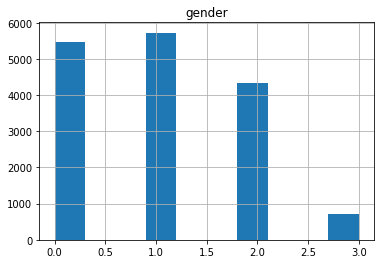

In [8]:
def gender_to_id(gender):
    return { 'male':0, 'female':1,'brand': 2, 'unknown':3}[gender]
plt.show(pd.DataFrame(data.gender.apply(gender_to_id)).hist())

We can see that our train data is quite balanced.<br>
Female (#1) tweets are the most common tweets in this data.
Let's look for term frequency per gender in the text field.
#### Term Frequency

In [9]:
def get_genders_words(data):
    Male = data[data['gender'] == 'male']
    Female = data[data['gender'] == 'female']
    Brand = data[data['gender'] == 'brand']
    Unk = data[data['gender'] == 'unknown']

    Male_Words = pd.Series(' '.join(Male['text'].astype(str)).lower().split(" ")).value_counts()[:20]
    Female_Words = pd.Series(' '.join(Female['text'].astype(str)).lower().split(" ")).value_counts()[:20]
    Brand_words = pd.Series(' '.join(Brand['text'].astype(str)).lower().split(" ")).value_counts()[:10]
    Unk_words = pd.Series(' '.join(Unk['text'].astype(str)).lower().split(" ")).value_counts()[:10]
    return Male_Words,Female_Words,Brand_words,Unk_words

def print_and_plot(words):
    print(words)
    words.plot(kind='bar',stacked=True)
Male_Words,Female_Words,Brand_words,Unk_words = get_genders_words(data)

Female most common words:
-----------------
the     4089
and     4040
i       2397
to      2005
a       1370
you     1261
my      1106
of      1104
in      1061
for      972
is       914
me       729
on       649
it       647
that     572
with     561
so       555
just     534
i'm      467
this     459
dtype: int64


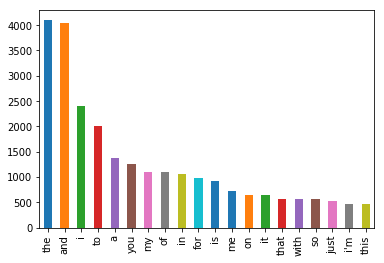

In [10]:
print("Female most common words:\n-----------------")
print_and_plot(Female_Words)

Male most common words:
-----------------
the     4405
and     3481
to      1745
i       1606
a       1567
of      1272
you     1134
in      1009
for      935
is       881
on       722
it       598
my       578
that     533
         530
with     473
be       448
have     434
me       417
just     401
dtype: int64


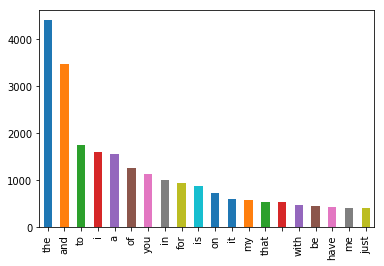

In [11]:
print("Male most common words:\n-----------------")
print_and_plot(Male_Words)

Brand most common words:
-----------------
the    3363
and    2513
to     1277
of     1061
a       909
in      776
for     769
is      630
on      560
you     554
dtype: int64


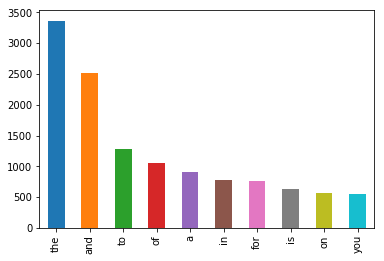

In [12]:
print("Brand most common words:\n-----------------")
print_and_plot(Brand_words)

Unkown most common words:
-----------------
the    546
and    457
i      239
to     223
a      203
of     183
you    151
is     118
in     114
it     111
dtype: int64


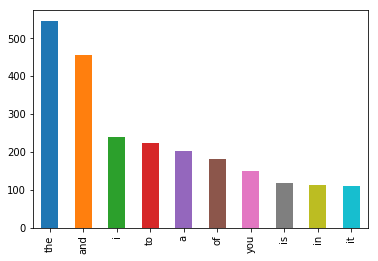

In [13]:
print("Unkown most common words:\n-----------------")
print_and_plot(Unk_words)

We can see alot of stop words. For example: "the" in the first place for each gender.<br>
We will take care of the stop words in the preprocessing stage

### Pre Processing Stage
We will have more data exploration in the next cells during the pre-proccesing stages.<br>

Now we will tokenize the sentences of the description and the text, <br>
We will remove stop words and other problematic tokens, and lemmatize each token.<br>
For this task we will use regex.

In [14]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'the',u'\u2019',u'\u2026','The',u'de',u'\xe9']

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>',                       # HTML tags
    r'(?:@[\w_]+)',                   # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',     # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",      # words with - and '
    r'(?:[\w_]+)',                    # other words
    r'(?:\S)'                         # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

def tokenize(s):
    s = cleaning(str(s))
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    lemmatizer = WordNetLemmatizer()
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    tokens = [lemmatizer.lemmatize(token) if not emoticon_re.search(token) else token for token in tokens]
    return tokens

In [15]:
data['text'] = [preprocess(s) for s in data['text']]
data['description'] = [preprocess(s) for s in data['description']]

data['text'] = data['text'].apply(lambda x : [item for item in x if item not in stop])
data['description'] = data['description'].apply(lambda x : [item for item in x if item not in stop])
data.head()

,_unit_id,gender,gender:confidence,description,name,sidebar_color,text
0,815719226,male,1.0000,"[sing, rhythm]",sheezy0,FFFFFF,"[robbie, e, responds, critic, win, eddie, edwa..."
1,815719227,male,1.0000,"[author, novel, filled, family, drama, romance]",DavdBurnett,C0DEED,"[ûïit, felt, like, friend, wa, living, story, ..."
2,815719228,male,0.6625,"[louis, whining, squealing]",lwtprettylaugh,C0DEED,"[absolutely, adore, louis, start, song, hit, h..."
3,815719229,male,1.0000,"[mobile, guy, er, shazam, google, kleiner, per...",douggarland,C0DEED,"[hi, jordanspieth, looking, url, use, ifttt, t..."
4,815719230,female,1.0000,"[ricky, wilson, best, frontman, kaiser, chief,...",WilfordGemma,0,"[watching, neighbour, sky, catching, neighbs, ..."


We would like to focus on the 10,000 most common words, because they are most likely to indicate a pattern. In addition, we can't know in advance which words will show up in the test set, so we filter the less common words in the training set from the test set.
In order to do so, we will take all the words from the 'text' and 'description' columns, find the most common words in them, and then filter out the words that are not included in that group.

In [16]:
all_words = []
data.description.apply(lambda x: all_words.extend(x))
data.text.apply(lambda x: all_words.extend(x))
all_words[:10]

['sing',
 'rhythm',
 'author',
 'novel',
 'filled',
 'family',
 'drama',
 'romance',
 'louis',
 'whining']

In [17]:
all_words = nltk.FreqDist(all_words)
top_words = all_words.most_common(10000)
top_words = list(map(lambda x: x[0], top_words))
top_words[:10]

['love', '_ù', 'like', 'û', 'get', 'one', 'ü', 'http', 'life', 'wa']

In [18]:
data.description = data.description.apply(lambda x: list(filter(lambda word: word in top_words, x)))
data.text = data.text.apply(lambda x: list(filter(lambda word: word in top_words, x)))
data.head()

,_unit_id,gender,gender:confidence,description,name,sidebar_color,text
0,815719226,male,1.0000,"[sing, rhythm]",sheezy0,FFFFFF,"[e, critic, win, eddie, edward]"
1,815719227,male,1.0000,"[author, novel, filled, family, drama, romance]",DavdBurnett,C0DEED,"[felt, like, friend, wa, living, story, û, ret..."
2,815719228,male,0.6625,"[louis, whining]",lwtprettylaugh,C0DEED,"[absolutely, adore, louis, start, song, hit, h..."
3,815719229,male,1.0000,"[mobile, guy, er, google, yahoo, sprint, pc, a...",douggarland,C0DEED,"[hi, looking, url, use, typically, see, advanc..."
4,815719230,female,1.0000,"[ricky, wilson, best, chief, best, band, xxxx,...",WilfordGemma,0,"[watching, neighbour, sky, catching, xxx, _ù, ..."


Let's see the most common words by gender after this pre-process:

In [19]:
Male_Words,Female_Words,Brand_words,Unk_words = get_genders_words(data)

'_ù',        295
'get',       280
'wa',        277
'like',      273
'one',       183
'time',      172
'go',        172
'new',       164
'day',       152
'love',      151
'make',      145
'people',    130
'û_']        126
'amp',       126
'â_ù',       120
'u',         119
'see',       118
'year',      117
'ha',        115
'back',      113
dtype: int64


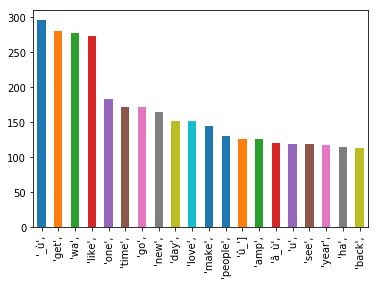

In [20]:
print_and_plot(Male_Words)

'_ù',        651
'like',      323
'wa',        306
'get',       284
'_ù']        270
'day',       254
'__ù',       244
'one',       238
'go',        220
'love',      215
'time',      197
'make',      184
'amp',       163
'people',    160
'u',         160
'â_ù',       156
'û_']        148
'new',       139
'know',      139
'thing',     136
dtype: int64


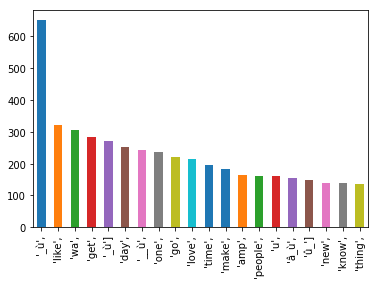

In [21]:
print_and_plot(Female_Words)

'weather',    300
'û_']         256
['get',       173
'new',        173
'u',          173
'amp',        166
'update',     162
'channel']    150
'get',        148
'wa',         124
dtype: int64


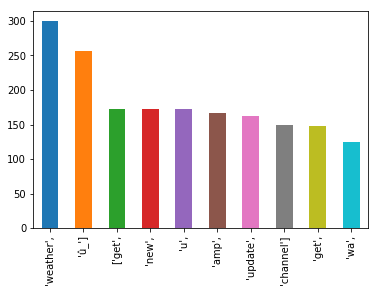

In [22]:
print_and_plot(Brand_words)

'wa',         40
'like',       38
'get',        31
'weather',    30
'make',       26
'go',         26
'_ù',         25
'one',        24
'love',       22
'people',     20
dtype: int64


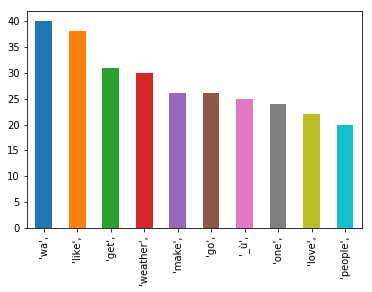

In [23]:
print_and_plot(Unk_words)

In order to build accurate models, we should check the gender confidence column in order to filter samples with low confidence. The tradeoff will between losing some data to train on and the quality of each sample.
Let's check what is the threshold that should be used in order to filter those records:

The percentage of records in the data with confidence of 90% is 0.7305


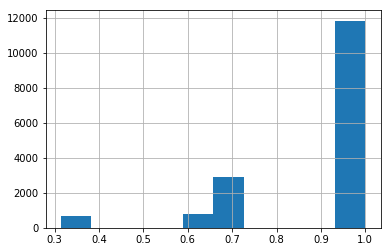

In [24]:
gender_conf = data['gender:confidence']

print('The percentage of records in the data with confidence of 90%% is %.4f' %
      (len(gender_conf[gender_conf >= 0.9]) / len(gender_conf),)
     )

plt.show(gender_conf.hist())

We will drop all records with gender confidence below 90% and remove the column since it's of no use anymore.

In [25]:
data = data[data['gender:confidence'] >= 0.9]
data.drop(['gender:confidence'], axis=1, inplace=True)

Now the data looks as follows:

In [26]:
data.head(10)

,_unit_id,gender,description,name,sidebar_color,text
0,815719226,male,"[sing, rhythm]",sheezy0,FFFFFF,"[e, critic, win, eddie, edward]"
1,815719227,male,"[author, novel, filled, family, drama, romance]",DavdBurnett,C0DEED,"[felt, like, friend, wa, living, story, û, ret..."
3,815719229,male,"[mobile, guy, er, google, yahoo, sprint, pc, a...",douggarland,C0DEED,"[hi, looking, url, use, typically, see, advanc..."
4,815719230,female,"[ricky, wilson, best, chief, best, band, xxxx,...",WilfordGemma,0,"[watching, neighbour, sky, catching, xxx, _ù, ..."
5,815719231,female,[know],monroevicious,0,"[ive, seen, people, train, chair, tv, etc]"
6,815719232,brand,"[global, marketplace, image, video, music, sha...",Shutterstock,0,"[thank, patience, take, care, issue]"
7,815719233,male,"[secret, getting, ahead, getting, started]",RobinMeske,C0DEED,"[gala, bingo, club, bought, å, uk, largest, hi..."
8,815719234,female,"[pll, fan, crazy, mcd, ramen, bae]",pigzilla_,0,"[pic, defines, mcd, mcd, shipper, xd]"
9,815719235,female,"[renaissance, art, historian, university, nott...",GabrieleNeher,FFFFFF,"[lovely, tree, year, never, seen, gorgeous, au..."
11,815719237,brand,"[highly, extraordinary, auction]",eliseotecleo,C0DEED,"[mtg, deal, x, rank, magic, one, en, secret, r..."


Let's look at the most common tweets location. It might affect our tweets steaming filtering later.

In [27]:
complete_data.user_timezone.value_counts()[:8]

Eastern Time (US & Canada)    2496
Pacific Time (US & Canada)    2106
Central Time (US & Canada)    1505
London                        1307
Atlantic Time (Canada)         589
Quito                          489
Amsterdam                      385
Arizona                        306
Name: user_timezone, dtype: int64

In [28]:
complete_data.tweet_location.value_counts()[:8]

London             152
United States      142
USA                 94
UK                  92
Los Angeles, CA     69
New York, NY        67
Worldwide           65
New York            62
Name: tweet_location, dtype: int64

We can see that most of the tweets are from US 

We will add one more column with bi-grams in order to have one more pre-process option later.
For this mission we will have to create our own encoder to make bigram to sequence.

In [29]:
def get_bigram_pd(data,col_name):
    bigram_pd = pd.DataFrame(data[col_name].apply(lambda sent:list(ngrams(sent,2))))
    return bigram_pd.rename(columns={col_name: 'bi_' + col_name})

def get_all_words_from_bigram(bigrams):
    all_bigrams = []
    bigrams.apply(lambda x:all_bigrams.append(x))
    return reduce(lambda acc,x:acc.union(x),all_bigrams,set())

def build_id_to_bi(bigrams):
    #reverse the dictionary
    bigram_to_id = {v:k for k,v in dict(enumerate(bigrams)).items()}
    #we will return the next function:
    def bi_to_id(bigram):
        # if the bigrams doesnt exists, return size+1
        if bigram in bigram_to_id: return bigram_to_id[bigram]
        return len(bigram_to_id) + 1
    return bi_to_id

In [30]:
# for description:
desc_bigram_pd = get_bigram_pd(data,'description')
all_desc_bigrams = get_all_words_from_bigram(desc_bigram_pd['bi_description'])

# for text:
text_bigram_pd = get_bigram_pd(data,'text')
all_text_bigrams = get_all_words_from_bigram(text_bigram_pd['bi_text'])

# build bi-gram to id function:
union_text_desc_bigrams = all_text_bigrams.union(all_desc_bigrams)
bi_to_id = build_id_to_bi(union_text_desc_bigrams)

In [31]:
data =  data.assign(bi_description=pd.Series(desc_bigram_pd['bi_description']).values,
                      bi_text=pd.Series(text_bigram_pd['bi_text']).values)

data.head()

,_unit_id,gender,description,name,sidebar_color,text,bi_description,bi_text
0,815719226,male,"[sing, rhythm]",sheezy0,FFFFFF,"[e, critic, win, eddie, edward]","[(sing, rhythm)]","[(e, critic), (critic, win), (win, eddie), (ed..."
1,815719227,male,"[author, novel, filled, family, drama, romance]",DavdBurnett,C0DEED,"[felt, like, friend, wa, living, story, û, ret...","[(author, novel), (novel, filled), (filled, fa...","[(felt, like), (like, friend), (friend, wa), (..."
3,815719229,male,"[mobile, guy, er, google, yahoo, sprint, pc, a...",douggarland,C0DEED,"[hi, looking, url, use, typically, see, advanc...","[(mobile, guy), (guy, er), (er, google), (goog...","[(hi, looking), (looking, url), (url, use), (u..."
4,815719230,female,"[ricky, wilson, best, chief, best, band, xxxx,...",WilfordGemma,0,"[watching, neighbour, sky, catching, xxx, _ù, ...","[(ricky, wilson), (wilson, best), (best, chief...","[(watching, neighbour), (neighbour, sky), (sky..."
5,815719231,female,[know],monroevicious,0,"[ive, seen, people, train, chair, tv, etc]",[],"[(ive, seen), (seen, people), (people, train),..."


We will turn the bigrams to sequences

In [32]:
data.bi_description = data.bi_description.apply(lambda bigrams:[bi_to_id(gram) for gram in bigrams])
data.bi_text = data.bi_text.apply(lambda bigrams:[bi_to_id(gram) for gram in bigrams])
data.head(3)

,_unit_id,gender,description,name,sidebar_color,text,bi_description,bi_text
0,815719226,male,"[sing, rhythm]",sheezy0,FFFFFF,"[e, critic, win, eddie, edward]",[37192],"[103734, 55900, 58028, 5830]"
1,815719227,male,"[author, novel, filled, family, drama, romance]",DavdBurnett,C0DEED,"[felt, like, friend, wa, living, story, û, ret...","[33216, 75996, 121089, 19206, 62761]","[39692, 65852, 41345, 10638, 114340, 105299, 1..."
3,815719229,male,"[mobile, guy, er, google, yahoo, sprint, pc, a...",douggarland,C0DEED,"[hi, looking, url, use, typically, see, advanc...","[13806, 37989, 4239, 120072, 49622, 120129, 75...","[35875, 25105, 64432, 119550, 7817, 41064, 51666]"


We will turn the numerical categories to numbers in order to 'feed' our models with the right format.<br>
But beforehand, we want to split the names to chars and then to use the 4 first letters as a feature.

In [33]:
data_ml = data.copy()

In [34]:
data.name = data['name'].apply(lambda x: list(x.lower())[:4])
data.head()

,_unit_id,gender,description,name,sidebar_color,text,bi_description,bi_text
0,815719226,male,"[sing, rhythm]","[s, h, e, e]",FFFFFF,"[e, critic, win, eddie, edward]",[37192],"[103734, 55900, 58028, 5830]"
1,815719227,male,"[author, novel, filled, family, drama, romance]","[d, a, v, d]",C0DEED,"[felt, like, friend, wa, living, story, û, ret...","[33216, 75996, 121089, 19206, 62761]","[39692, 65852, 41345, 10638, 114340, 105299, 1..."
3,815719229,male,"[mobile, guy, er, google, yahoo, sprint, pc, a...","[d, o, u, g]",C0DEED,"[hi, looking, url, use, typically, see, advanc...","[13806, 37989, 4239, 120072, 49622, 120129, 75...","[35875, 25105, 64432, 119550, 7817, 41064, 51666]"
4,815719230,female,"[ricky, wilson, best, chief, best, band, xxxx,...","[w, i, l, f]",0,"[watching, neighbour, sky, catching, xxx, _ù, ...","[13489, 90905, 28629, 61068, 59311, 86882, 468...","[27570, 66407, 98149, 99001, 20957, 57994, 102..."
5,815719231,female,[know],"[m, o, n, r]",0,"[ive, seen, people, train, chair, tv, etc]",[],"[119842, 84424, 797, 106481, 35876, 7124]"


Now, we will get back to the preprocess and we will change the numerical features to numbers.<br>
The name chars will be treated as chars vocabulary encoding and will be presented as a sequence.<br>
For this task we will use some sklearn and nltk functions such as Tokenizer, fit_on_texts, pad_sequences, etc.<br>
In order to choose an optimal length for padding we will look on the mean length of the text and of the description.<br>


In [35]:
print("text mean length {}".format(round(data.text.apply(len).mean())))
print("description mean length {}".format(round(data.description.apply(len).mean())))
print("name mean length {}".format(round(data.name.apply(len).mean())))
print("bi_text mean length {}".format(round(data.bi_text.apply(len).mean())))
print("bi_description mean length {}".format(round(data.bi_description.apply(len).mean())))

text mean length 8.0
description mean length 8.0
name mean length 4.0
bi_text mean length 7.0
bi_description mean length 7.0


We will choose to pad the text and the description columns values to a  length of 10.

In [36]:
vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(data.text.apply(lambda words: ' '.join(words)))
tokenizer.fit_on_texts(data.description.apply(lambda words: ' '.join(words)))

text_sequence = tokenizer.texts_to_sequences(data.text)
description_sequence = tokenizer.texts_to_sequences(data.description)

text_data = pad_sequences(text_sequence, maxlen=10,padding='post')
description_data = pad_sequences(description_sequence, maxlen=10,padding='post')
bi_text_data = pad_sequences(data.bi_text, maxlen=10,padding='post')
bi_description_data = pad_sequences(data.bi_description, maxlen=10,padding='post')

bi_description_data[0]

array([37192,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

Now we will tokenize the first 4 letters of the name with a new Tokenizer for chars

In [37]:
all_names_letters = reduce(lambda acc,new: acc + new, data.name, [])
number_of_unique_names = len(set(all_names_letters))
print("number of unique names {}".format(number_of_unique_names))

number of unique names 37


In [38]:
name_tokenizer = Tokenizer(num_words= number_of_unique_names, char_level=True)
name_tokenizer.fit_on_texts(data.name.apply(lambda words: ''.join(words)))
name_data = name_tokenizer.texts_to_sequences(data.name)
name_data = pad_sequences(name_data, maxlen=4,padding='post')
name_data = [np.array(lst) for lst in name_data]

Now our data set is divided into to 3:<br>
1. text_data
2. description_data
3. name_data<br>

We will create the labels (classes) by converting gender to id in the next cell

In [39]:
# convert genders from female and male to 1 and 0 respectively
y_data = data.gender.apply(lambda gender : gender_to_id(gender)).values
y_data[:5]

array([0, 0, 0, 1, 1])

In [40]:
X_data = {'text':list(text_data),
          'description':list(description_data),
          'bi_text':list(bi_text_data),
          'bi_description':list(bi_description_data),
          'name_letters':name_data,
          'target':list(y_data)}
lstm_data = pd.DataFrame.from_dict(X_data)

In [41]:
lstm_data.head(5)

,text,description,bi_text,bi_description,name_letters,target
0,"[193, 1944, 235, 3964, 3965, 0, 0, 0, 0, 0]","[1748, 6387, 0, 0, 0, 0, 0, 0, 0, 0]","[103734, 55900, 58028, 5830, 0, 0, 0, 0, 0, 0]","[37192, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 12, 2, 2]",0
1,"[1856, 5, 50, 11, 164, 152, 2, 971, 5804, 0]","[161, 1474, 2390, 79, 2324, 1712, 0, 0, 0, 0]","[39692, 65852, 41345, 10638, 114340, 105299, 1...","[33216, 75996, 121089, 19206, 62761, 0, 0, 0, ...","[13, 1, 24, 13]",0
2,"[274, 211, 5805, 171, 6988, 31, 2237, 1388, 0, 0]","[6337, 1401, 738, 918, 3341, 5404, 230, 271, 3...","[35875, 25105, 64432, 119550, 7817, 41064, 516...","[49622, 120129, 75138, 15720, 10242, 106995, 6...","[13, 7, 15, 19]",0
3,"[504, 6989, 1312, 4413, 1945, 698, 1945, 0, 0, 0]","[553, 5377, 167, 705, 1334, 28, 3642, 1221, 65...","[27570, 66407, 98149, 99001, 20957, 57994, 102...","[59311, 86882, 46896, 11440, 92016, 1078, 1152...","[23, 3, 6, 22]",1
4,"[1630, 471, 19, 838, 1446, 157, 757, 0, 0, 0]","[24, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[119842, 84424, 797, 106481, 35876, 7124, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10, 7, 9, 4]",1


### Q2<br>

For this mission we will use 3 features: text, description and the first 4 letters of the name.<br>
We will have to concatenate the first two features (text and description) in order to use MultinomialNB and LogisticRegression.<br>
We are using Pipeline with CounterVectorizer and TFIDF so for the next two machine learning models we will use data_ml which is not a sequence of words but it was pre-proccessed.

In [42]:
text_as_description =  data_ml[['description']].rename(columns={'description': 'text'})
text_as_name = pd.DataFrame(data_ml.name.apply(lambda x:[x[:4].lower()])).rename(columns={'name': 'text'})
X_data = data_ml[['text']] + text_as_description + text_as_name
X_data = X_data['text'].apply(lambda x: ' '.join(x))
y_data = data_ml[['gender']]
encoder = LabelEncoder()
y_data = pd.DataFrame(encoder.fit_transform(np.array(y_data).ravel()))

In [43]:
X_data, X_test, y_data, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

We will first use a naiive prediction to create a baseline benchmark.
In order to do so, we will predict all genders to be 'male' or all genders to be 'female' and test the accuracy of the results:

In [44]:
y_pred_male = np.tile(gender_to_id('male'), len(y_test))
y_pred_female = np.tile(gender_to_id('female'), len(y_test))

y_pred_male_train = np.tile(gender_to_id('male'), len(y_data))
y_pred_female_train = np.tile(gender_to_id('female'), len(y_data))

print("Naiive 'male' prediction accuracy on train : {}\nNaiive 'female' prediction accuracy on train : {}".format(
    accuracy_score(y_data, y_pred_male_train),
    accuracy_score(y_data, y_pred_female_train))
     )

print("Naiive 'male' prediction accuracy on test: {}\nNaiive 'female' prediction accuracy on test: {}".format(
    accuracy_score(y_test, y_pred_male),
    accuracy_score(y_test, y_pred_female))
     )

Naiive 'male' prediction accuracy on train : 0.2528481012658228
Naiive 'female' prediction accuracy on train : 0.3876582278481013
Naiive 'male' prediction accuracy on test: 0.2585407001265289
Naiive 'female' prediction accuracy on test: 0.39730071699704766


We can see that the accuracy score for a naiive model that guesses the gender of the author to be constantly male, or constantly female is not good enough, with only 25%-39% accuracy.
We would like to improve that prediction by using more complicated models.

We will train a machine learning model to predict the gender of the tweets' authors.<br>
We will use k-fold cross validation with the train data and then we will present test accuracy results.<br>
For the third model which is LSTM we will use naive train\test split.<br>
We will use pipeline with two features, Count vectorizer and tfidf.<br>
Since we need to try two combinations, we will consider Countvectorizer with uni-gram as the first combination
and unigram and bigram as the second one.<br>
Then, we will choose the best model and we will tune hyperparams.

In [45]:
############## utils ##############
def flatten(lst):
    return list(map(lambda x:x[0],lst))

def show_confusion_matrix(confusion_mat,classes,title = ''):
    range_of_classes = list(range(len(classes)))
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(confusion_mat,cmap='Greens',annot=True,linewidths=1.0, fmt='d',ax=ax)
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title(title)
    plt.xticks(range_of_classes, classes, rotation=45)
    plt.yticks(range_of_classes, classes,rotation=0)
    plt.show()
###################################

def build_pipeline(model,ngram_range=(1,1)):
    return Pipeline([
        ('vect', CountVectorizer(ngram_range=ngram_range)),
        ('tfidf', TfidfTransformer()),
        ('model', model)])


def train(model,X_train, y_train, n_folds = 6,ngram_range=(1,1)):
    classes = [0, 1, 2, 3]
    confusion = np.zeros((len(classes),len(classes)),dtype=int)
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline(model,ngram_range)
    scores = []
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(X_train)):
        train_text = X_train.iloc[train_indices].values.tolist()
        train_y = y_train.iloc[train_indices].values.tolist()

        test_text = X_train.iloc[test_indices].values.tolist()
        test_y = y_train.iloc[test_indices].values.tolist()
        
        print("Training for fold %d" % i)
        train_y = np.array(train_y)
        pipeline.fit(train_text, train_y.ravel())
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions,labels=classes)


        score = accuracy_score(test_y, predictions)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("-------------------")

    print('Total corpus classified:', len(X_train))
    print('Score:', round(sum(scores)/len(scores),5))
    show_confusion_matrix(confusion,classes,title="Confusion Matrix")
    return pipeline, round(sum(scores)/len(scores),5)

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.66
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.66
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.66
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.67
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.69
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.66
-------------------
Total corpus classified: 9480
Score: 0.66614


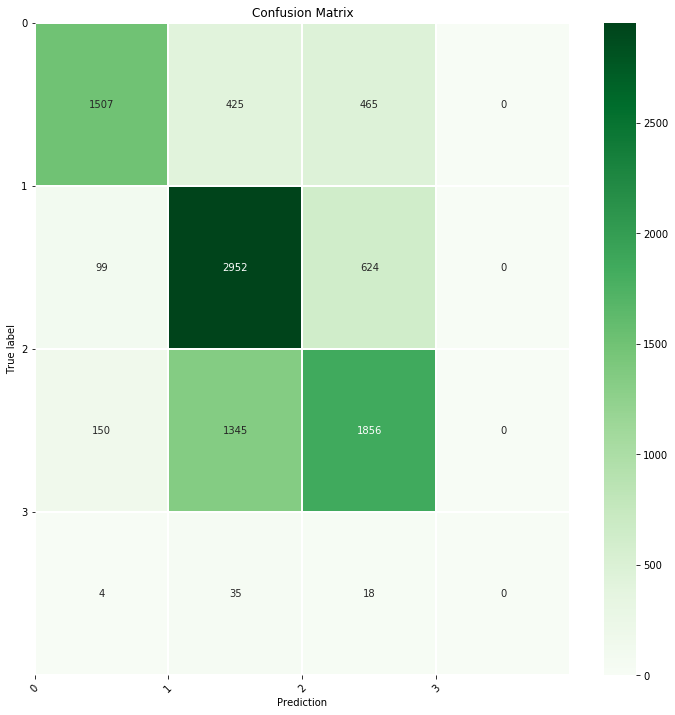

In [46]:
pipeline,val_score_NB_unigram = train(MultinomialNB(),X_data,y_data)

Results on test :

In [47]:
multinomial_nb_not_tuned = build_pipeline(MultinomialNB())
multinomial_nb_not_tuned.fit(X_data,np.array(y_data).ravel())

y_nb_preds = multinomial_nb_not_tuned.predict(X_test)
test_score_NB_unigram = accuracy_score(y_test,y_nb_preds)
print("test score {}".format(test_score_NB_unigram))

test score 0.6638549135385913


And now we will add bi-grams as a new pre-process combination

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.64
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.65
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.64
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.64
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.66
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.65
-------------------
Total corpus classified: 9480
Score: 0.64726


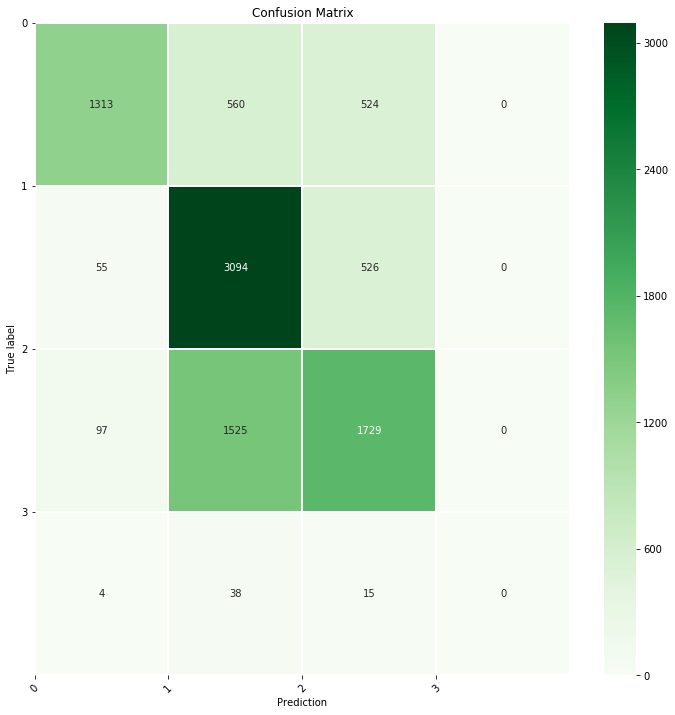

In [48]:
pipeline,val_score_NB_bigram = train(MultinomialNB(),X_data,y_data,ngram_range=(1,2))

So, we can see that there is no improvment.<br>
we will show the test results as we asked to do

In [49]:
multinomial_nb_bgigram = build_pipeline(MultinomialNB(),ngram_range=(1,2))
multinomial_nb_bgigram.fit(X_data,np.array(y_data).ravel())

y_nb_preds2 = multinomial_nb_bgigram.predict(X_test)
test_score_NB_bigram = accuracy_score(y_test,y_nb_preds2)
print("test score {}".format(test_score_NB_bigram))

test score 0.6482496836777731


So, we were asked to try different pre-processing and parameters tuning combinations.<br>
We consider the ngram_range (1,1) and (1,2) as two different pre-process.<br>
Now, we will try to tune the model with the alpha parameter for the MultinomialNB.<br>
For this task, we will change the train method which uses k-fold to do less prints and to return the best model among the alpha options that we will try.

In [50]:
def train2(model,X_train, y_train, n_folds = 6,ngram_range=(1,1)):
    classes = [0, 1, 2, 3]
    confusion = np.zeros((len(classes),len(classes)),dtype=int)
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline(model,ngram_range)
    scores = []
    for i, (train_indices, test_indices) in enumerate(k_fold.split(X_train)):
        train_text = X_train.iloc[train_indices].values.tolist()
        train_y = y_train.iloc[train_indices].values.tolist()

        test_text = X_train.iloc[test_indices].values.tolist()
        test_y = y_train.iloc[test_indices].values.tolist()
        
        pipeline.fit(train_text, np.array(train_y).ravel())
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions,labels=classes)


        score = accuracy_score(test_y, predictions)
        scores.append(score)
        


    print('Total corpus classified:', len(X_train))
    print('Score:', round(sum(scores)/len(scores),5))
    show_confusion_matrix(confusion,classes,title="Confusion Matrix")
    return pipeline,score

def find_optimal_alpha(alpha_range):
    scores = {}
    for alpha in alpha_range:
        print("alpha {}".format(alpha))
        _,score = train2(MultinomialNB(alpha),X_data,y_data) 
        scores[alpha] = score
    return scores

alpha 0.1
Total corpus classified: 9480
Score: 0.66814


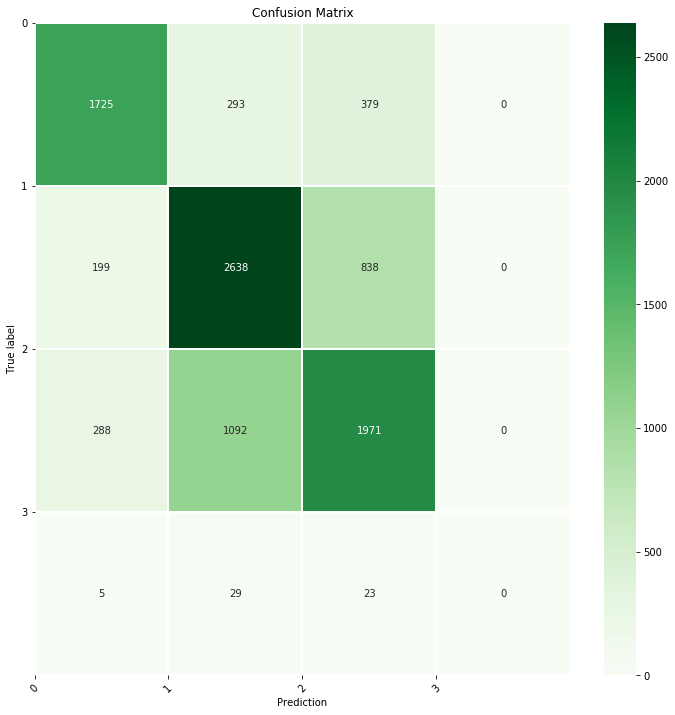

alpha 0.2
Total corpus classified: 9480
Score: 0.67859


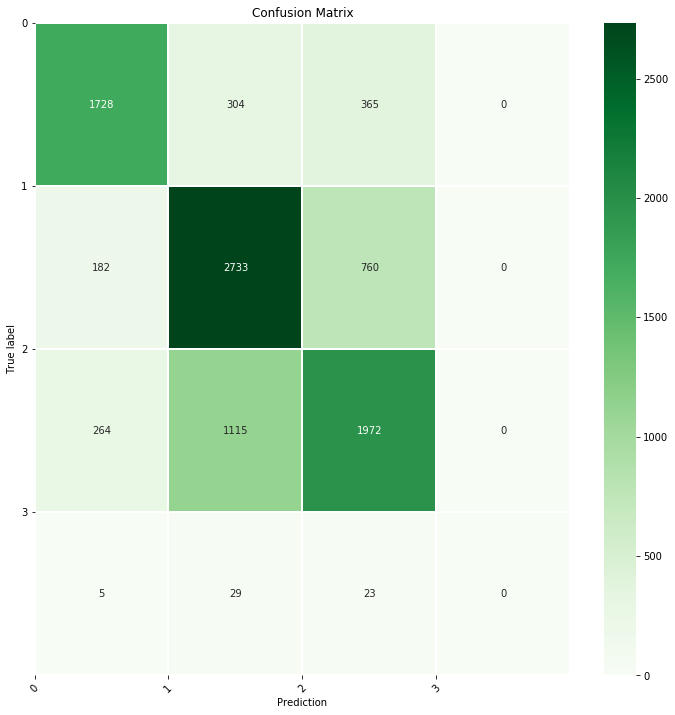

alpha 0.3
Total corpus classified: 9480
Score: 0.68101


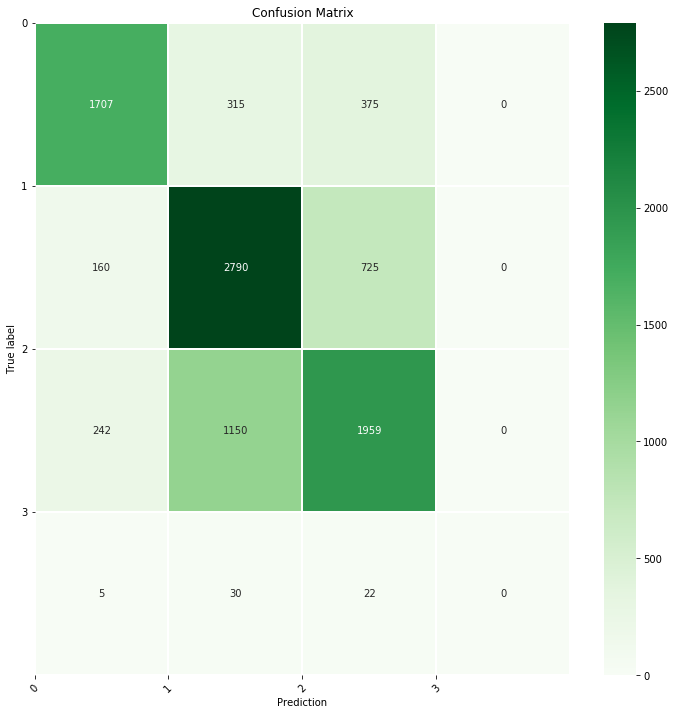

alpha 0.4
Total corpus classified: 9480
Score: 0.68228


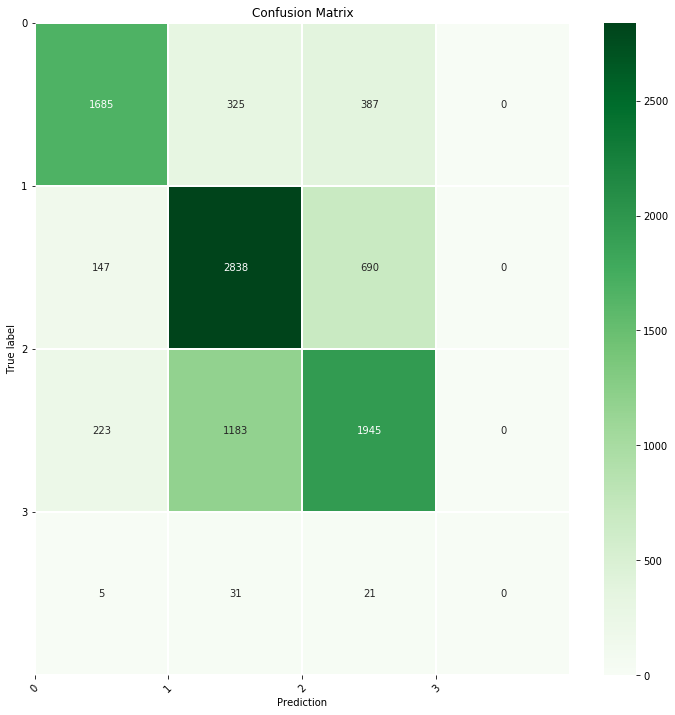

alpha 0.5
Total corpus classified: 9480
Score: 0.68091


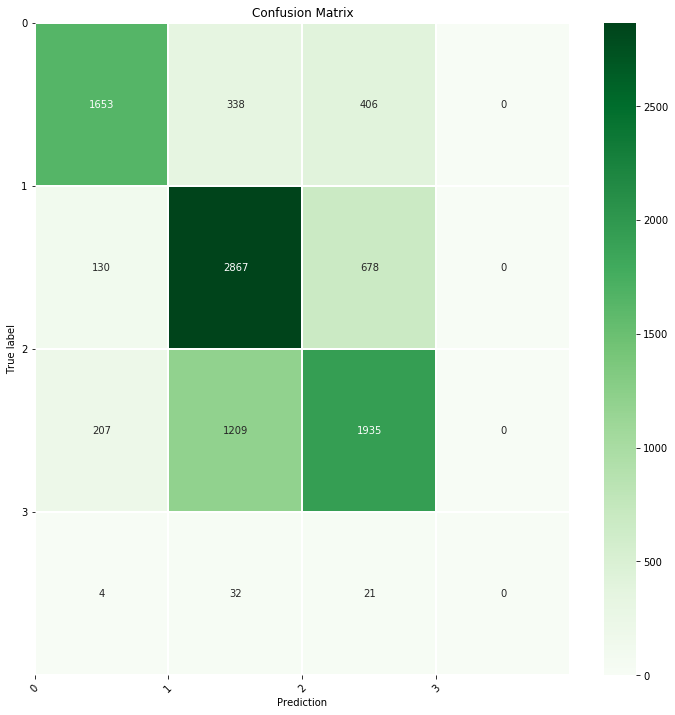

alpha 0.6
Total corpus classified: 9480
Score: 0.67848


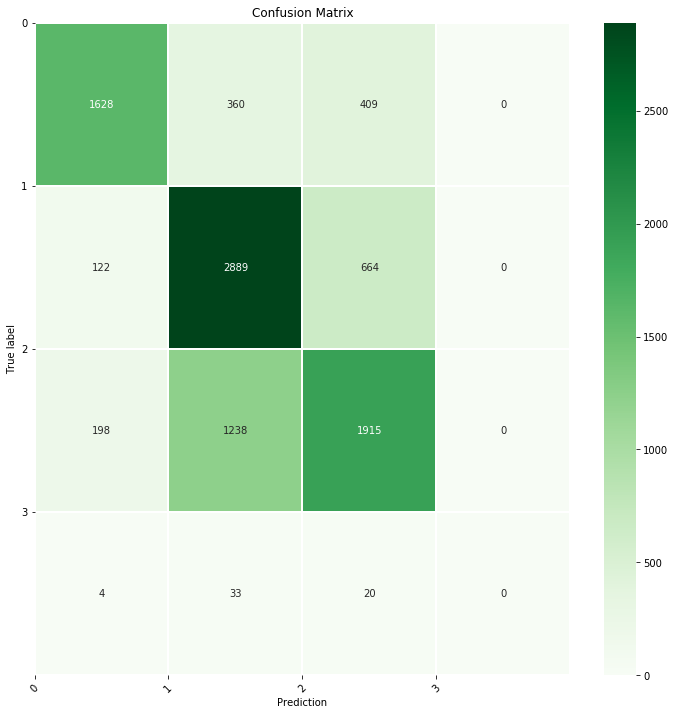

alpha 0.7
Total corpus classified: 9480
Score: 0.67648


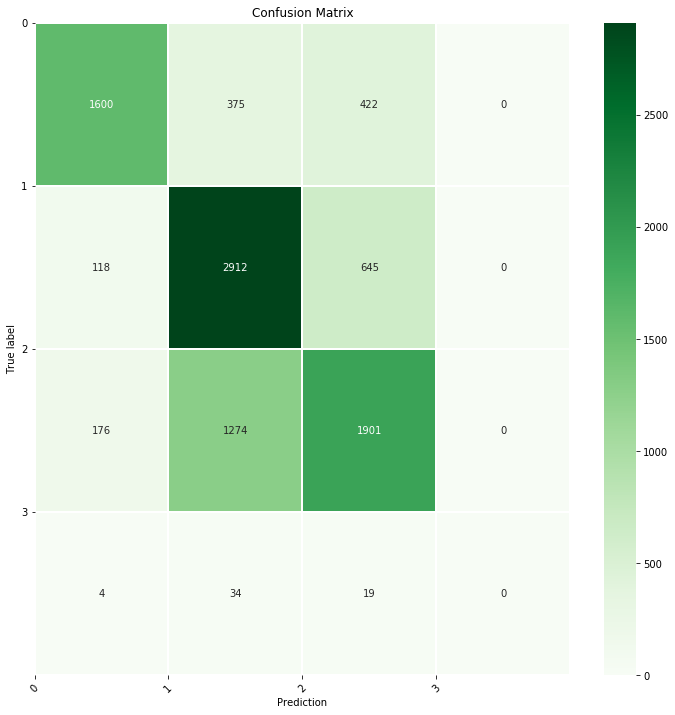

alpha 0.8
Total corpus classified: 9480
Score: 0.67215


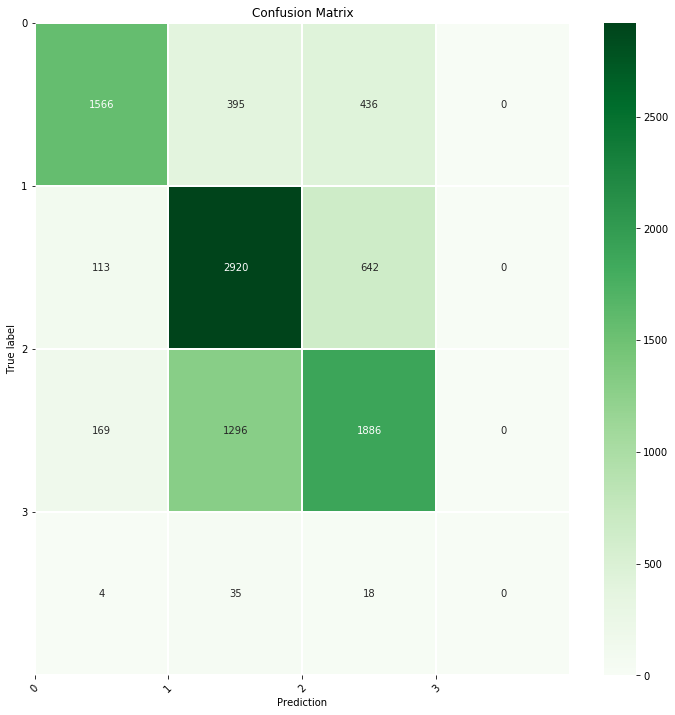

alpha 0.9
Total corpus classified: 9480
Score: 0.67057


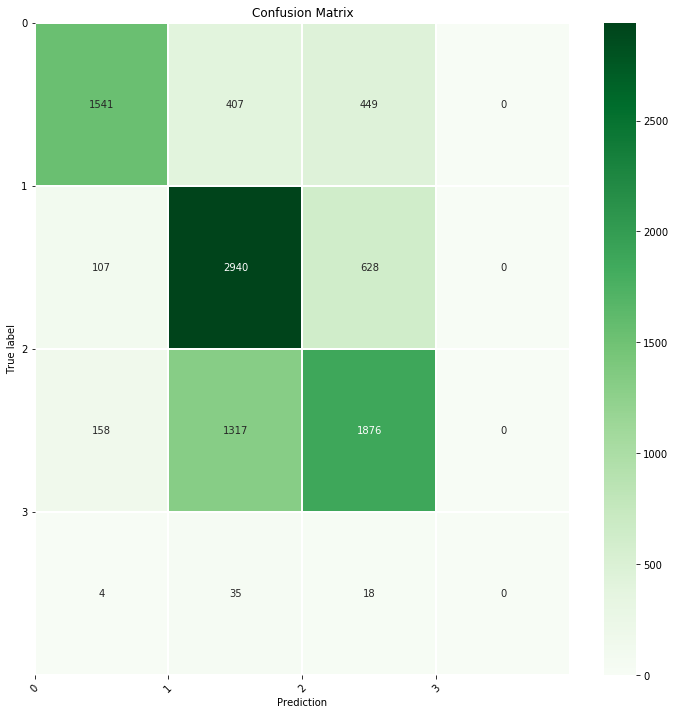

{0.1: 0.6620253164556962,
 0.2: 0.6772151898734177,
 0.3: 0.6797468354430379,
 0.4: 0.6810126582278481,
 0.5: 0.6791139240506329,
 0.6: 0.6734177215189874,
 0.7: 0.670253164556962,
 0.8: 0.6677215189873418,
 0.9: 0.6670886075949367}

In [51]:
alpha_range = [i/10 for i in range(1,10)]
scores = find_optimal_alpha(alpha_range)
scores

alpha 0.1 and score 0.662
alpha 0.2 and score 0.6772
alpha 0.3 and score 0.6797
alpha 0.4 and score 0.681
alpha 0.5 and score 0.6791
alpha 0.6 and score 0.6734
alpha 0.7 and score 0.6703
alpha 0.8 and score 0.6677
alpha 0.9 and score 0.6671


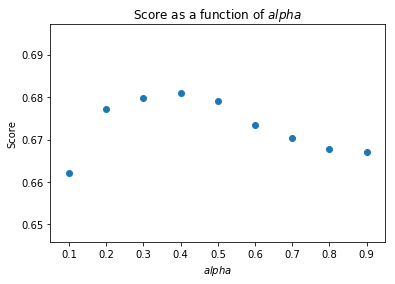

In [52]:
for alpha,score in scores.items():
    print("alpha {} and score {}".format(alpha,round(score,4)))
plt.scatter(scores.keys(),scores.values())
plt.xlabel(xlabel='$alpha$')
plt.ylabel(ylabel='Score')
plt.title("Score as a function of $alpha$")
plt.show()

As we can see in the graph, $alpha = 0.4$ is the optimal alpha for this model, with val accuracy = 0.49 (best until now).<br>
Let's see the results on the test

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.68
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.68
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.67
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.69
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.69
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.68
-------------------
Total corpus classified: 9480
Score: 0.68228


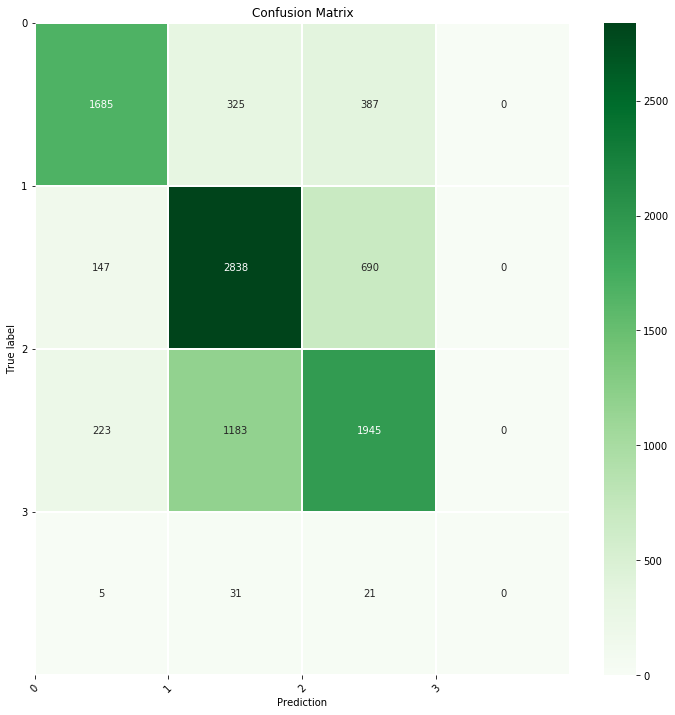

test score 0.667650780261493


In [105]:
alpha = 0.4
optimal_alpha_nb,val_score_NB_alpha_opt = train(MultinomialNB(alpha = alpha),X_data,y_data) 

y_optimal_nb_preds = optimal_alpha_nb.predict(X_test)
test_score_NB_alpha_opt = accuracy_score(y_test,y_optimal_nb_preds)
print("test score {}".format(test_score_NB_alpha_opt))

Now for the second model,let's try with LogisticRegression.

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.65
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.67
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.67
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.67
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.69
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.67
-------------------
Total corpus classified: 9480
Score: 0.67205


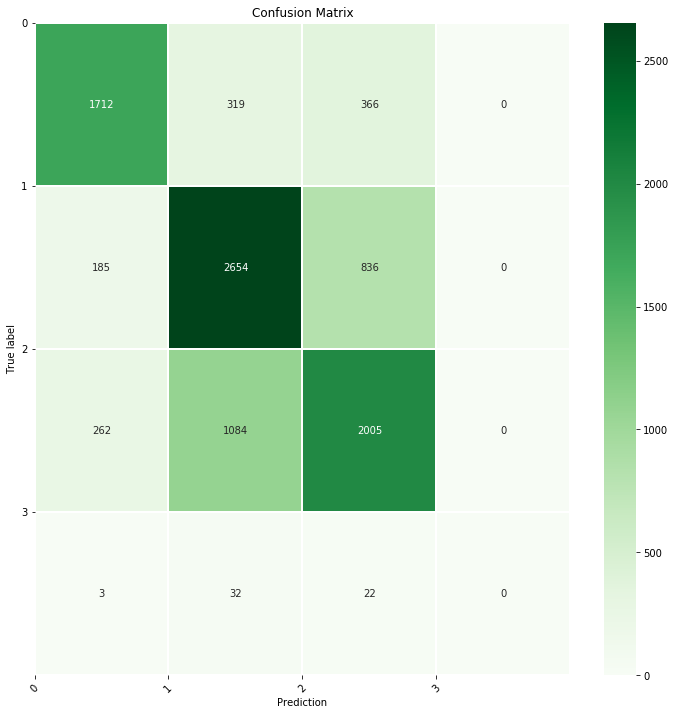

In [54]:
pipeline,val_score_LR_unigram = train(LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=250),X_data,y_data)

In [55]:
lrg_not_tuned = build_pipeline(LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=250))
lrg_not_tuned.fit(X_data,np.array(y_data).ravel())
y_lrg_preds = lrg_not_tuned.predict(X_test)
test_score_LR_unigram = accuracy_score(y_test,y_lrg_preds)
print("test score {}".format(test_score_LR_unigram))

test score 0.6642766765078026


And with bi-grams:

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.66
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.67
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.67
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.67
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.69
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.67
-------------------
Total corpus classified: 9480
Score: 0.67215


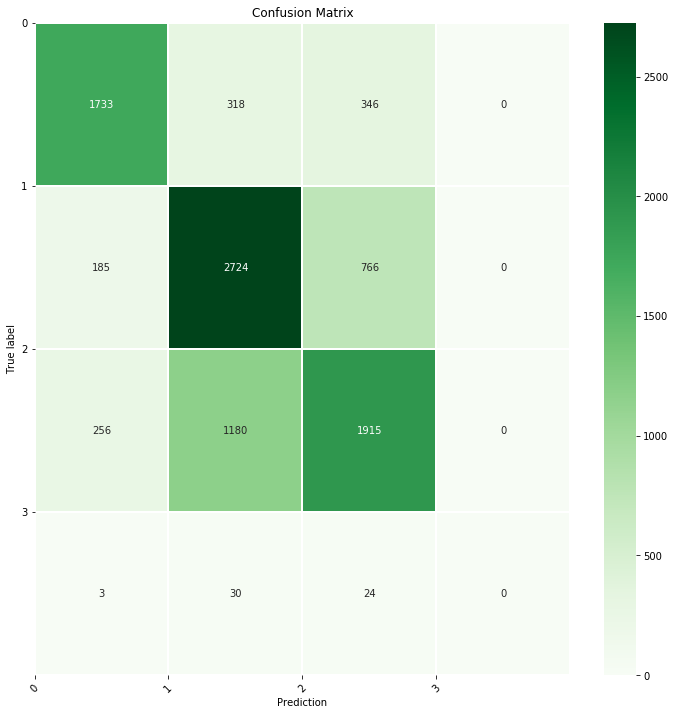

In [56]:
pipeline,val_score_LR_bigram = train(LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=250),X_data,y_data,ngram_range=(1,2))

In [57]:
lrg_bigram = build_pipeline(LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=250),ngram_range=(1,2))
lrg_bigram.fit(X_data,np.array(y_data).ravel())
y_lrg_preds2 = lrg_bigram.predict(X_test)
test_score_LR_bigram = accuracy_score(y_test,y_lrg_preds2)
print("test score {}".format(test_score_LR_bigram))

test score 0.6642766765078026


We got almost the same results on the validation. In the test we can see improvment. So the best model among these two is the logisticRegression with CountVectorizer using only unigrams.<br> We choose the best model according to the results on the validation only.

Now, we will tune the logisticRegression hyperParamer in order to improve the results.
We will use penalty = 'l2' as a tuned parameter.

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.65
-------------------
Training for fold 1
Testing for fold 1
Score for 1: 0.67
-------------------
Training for fold 2
Testing for fold 2
Score for 2: 0.67
-------------------
Training for fold 3
Testing for fold 3
Score for 3: 0.67
-------------------
Training for fold 4
Testing for fold 4
Score for 4: 0.69
-------------------
Training for fold 5
Testing for fold 5
Score for 5: 0.67
-------------------
Total corpus classified: 9480
Score: 0.67205


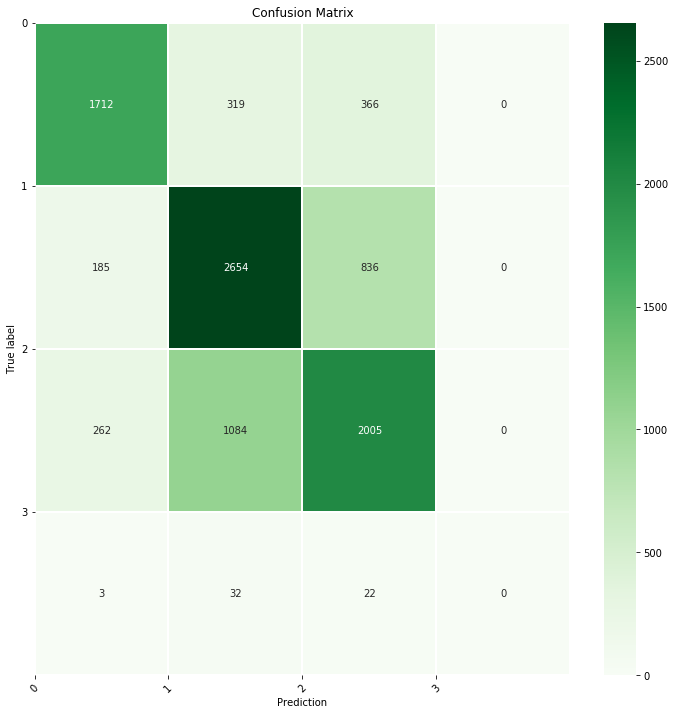

In [58]:
pipeline, val_score_LR_penalty = train(LogisticRegression(penalty='l2',solver='lbfgs',multi_class='auto',max_iter=250),X_data,y_data,ngram_range=(1,1))

There is no improvment... <br>
Let's see the test results

In [59]:
lrg_penalty = build_pipeline(LogisticRegression(penalty='l2',solver='lbfgs',multi_class='auto',max_iter=250))
lrg_penalty.fit(X_data,np.array(y_data).ravel())
y_lrg_preds3 = lrg_penalty.predict(X_test)
test_score_LR_penalty = accuracy_score(y_test,y_lrg_preds3)
print("test score {}".format(test_score_LR_penalty))

test score 0.6642766765078026


#### Now, we will use lstm as the thired model. 

In [60]:
X_data_for_lstm = lstm_data.drop('target',axis=1)
y_data_for_lstm = lstm_data.target.values
X_data_for_lstm, x_test_for_lstm, y_data_for_lstm, y_test_for_lstm = train_test_split(X_data_for_lstm, y_data_for_lstm, test_size=0.2, random_state=42)

In [61]:
def transform_df(X):
    return np.array([X.values[i].reshape(X.values[0].shape[0], 1) 
                     for i in range(X.values.shape[0])])

In [62]:
# train
x_text = transform_df(X_data_for_lstm['text'])
x_description = transform_df(X_data_for_lstm['description'])
x_bi_text = transform_df(X_data_for_lstm['bi_text'])
x_bi_description = transform_df(X_data_for_lstm['bi_description'])
x_name = transform_df(X_data_for_lstm['name_letters'])

# test
x_test_text = transform_df(x_test_for_lstm['text'])
x_test_description = transform_df(x_test_for_lstm['description'])
x_test_bi_text = transform_df(x_test_for_lstm['bi_text'])
x_test_bi_description = transform_df(x_test_for_lstm['bi_description'])
x_test_name = transform_df(x_test_for_lstm['name_letters'])

In [63]:
print('x_text shape = {}'.format(x_text.shape))
print('x_test_text shape = {}'.format(x_test_text.shape))

x_text shape = (9480, 10, 1)
x_test_text shape = (2371, 10, 1)


We will use relu activation for the first dense layer because we will not predict any negative numbers.<br>
For the second dense and the last one we will use softmax for probablistic results.<br>
Loss will be categorical_crossentropy and metric will be accuracy.<br>
We will take the best weight only by using callbacks

In [64]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(15,5))
    axs.plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs.plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()
    
def convert_to_one_hot(vecs):
    res = []
    for vec in vecs:
        res.append(np.argmax(vec))
    return res

def check_categorical_accuracy(y_true,y_pred):
    n_correct = 0
    for true,pred in zip(y_true,y_pred):
        if int(true) == int(pred):
            n_correct += 1
    return n_correct/y_true.size    



In [65]:
######hyper-params####
lstm_units = 10
ephocs = 40
batch_s = 32
#####################

In [66]:
text_inp = Input((10,1),name = 'text_input')
description_inp = Input((10,1),name = 'description_input')
name_input = Input((4,1),name = 'name_input')
inp = concatenate([text_inp,  description_inp, name_input],axis=1)
x = CuDNNLSTM(lstm_units)(inp)
x = Dense(10,activation='relu')(x)
x = Dense(4,activation= 'softmax')(x)
model = Model([text_inp,  description_inp, name_input],x)
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 10, 1)        0                                            
__________________________________________________________________________________________________
description_input (InputLayer)  (None, 10, 1)        0                                            
__________________________________________________________________________________________________
name_input (InputLayer)         (None, 4, 1)         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24, 1)        0           text_input[0][0]                 
                                                                 description_input[0][0]          
          

In [67]:
cp = ModelCheckpoint('best_model_weights.h5',save_best_only=True)
model_info = model.fit([x_text, x_description, x_name],
                            to_categorical(y_data_for_lstm),
                            batch_size=batch_s,
                            validation_split=0.2, 
                            epochs=ephocs, 
                            callbacks=[cp])

model.load_weights('best_model_weights.h5')

Train on 7584 samples, validate on 1896 samples
Epoch 1/40
7584/7584 [==============================] - 4s 483us/step - loss: 1.1676 - acc: 0.3859 - val_loss: 1.1031 - val_acc: 0.3829
Epoch 2/40
7584/7584 [==============================] - 1s 194us/step - loss: 1.0966 - acc: 0.4008 - val_loss: 1.0826 - val_acc: 0.3977
Epoch 3/40
7584/7584 [==============================] - 2s 210us/step - loss: 1.0735 - acc: 0.4386 - val_loss: 1.0686 - val_acc: 0.4372
Epoch 4/40
7584/7584 [==============================] - 1s 187us/step - loss: 1.0616 - acc: 0.4515 - val_loss: 1.0667 - val_acc: 0.4457
Epoch 5/40
7584/7584 [==============================] - 2s 230us/step - loss: 1.0569 - acc: 0.4594 - val_loss: 1.0645 - val_acc: 0.4399
Epoch 6/40
7584/7584 [==============================] - 1s 183us/step - loss: 1.0543 - acc: 0.4618 - val_loss: 1.0638 - val_acc: 0.4404
Epoch 7/40
7584/7584 [==============================] - 2s 206us/step - loss: 1.0537 - acc: 0.4629 - val_loss: 1.0624 - val_acc: 0.4420


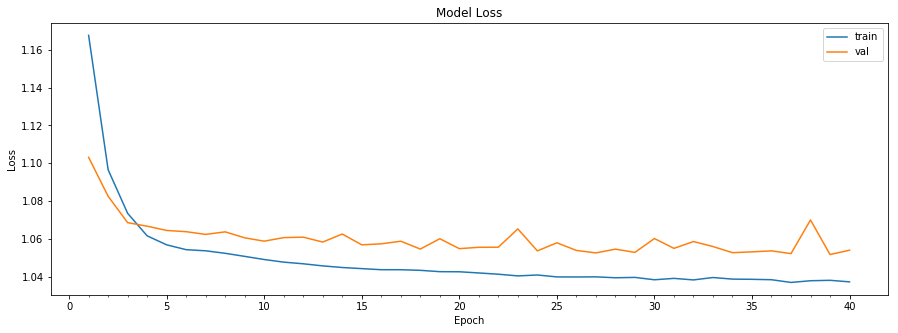

In [68]:
plot_model_history(model_info.history)

Results on test:

In [69]:
first_model_preds = model.predict([x_test_text, x_test_description, x_test_name])
model_test_score1 = check_categorical_accuracy(y_test_for_lstm,convert_to_one_hot(first_model_preds))
print("Score on test {}%".format(round(model_test_score1,4) * 100))

Score on test 47.11%


We will try another pre-process combination, this time we will use the bigrams column : bi_text and bi_description instead the unigrams.

In [70]:
text_inp = Input((10,1),name = 'text_input')
description_inp = Input((10,1),name = 'description_input')
name_input = Input((4,1),name = 'name_input')
inp = concatenate([text_inp,  description_inp, name_input],axis=1)
x = CuDNNLSTM(lstm_units)(inp)
x = Dense(10,activation='relu')(x)
x = Dense(4,activation= 'softmax')(x)
bi_grams_model = Model([text_inp,  description_inp, name_input],x)
bi_grams_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [71]:
cp = ModelCheckpoint('bigram_best_model_weights.h5',save_best_only=True)
bigram_model_info = bi_grams_model.fit([x_bi_text, x_bi_description, x_name],
                            to_categorical(y_data_for_lstm),
                            batch_size=batch_s,
                            validation_split=0.2, 
                            epochs=ephocs, 
                            callbacks=[cp])

bi_grams_model.load_weights('bigram_best_model_weights.h5')

Train on 7584 samples, validate on 1896 samples
Epoch 1/40
7584/7584 [==============================] - 2s 318us/step - loss: 1.1194 - acc: 0.4002 - val_loss: 1.0858 - val_acc: 0.4277
Epoch 2/40
7584/7584 [==============================] - 2s 228us/step - loss: 1.0790 - acc: 0.4218 - val_loss: 1.0778 - val_acc: 0.4225
Epoch 3/40
7584/7584 [==============================] - 2s 207us/step - loss: 1.0736 - acc: 0.4266 - val_loss: 1.0768 - val_acc: 0.4230
Epoch 4/40
7584/7584 [==============================] - 1s 171us/step - loss: 1.0728 - acc: 0.4317 - val_loss: 1.0763 - val_acc: 0.4146
Epoch 5/40
7584/7584 [==============================] - 2s 251us/step - loss: 1.0719 - acc: 0.4310 - val_loss: 1.0730 - val_acc: 0.4330
Epoch 6/40
7584/7584 [==============================] - 1s 197us/step - loss: 1.0716 - acc: 0.4357 - val_loss: 1.0739 - val_acc: 0.4251
Epoch 7/40
7584/7584 [==============================] - 2s 208us/step - loss: 1.0705 - acc: 0.4329 - val_loss: 1.0740 - val_acc: 0.4283


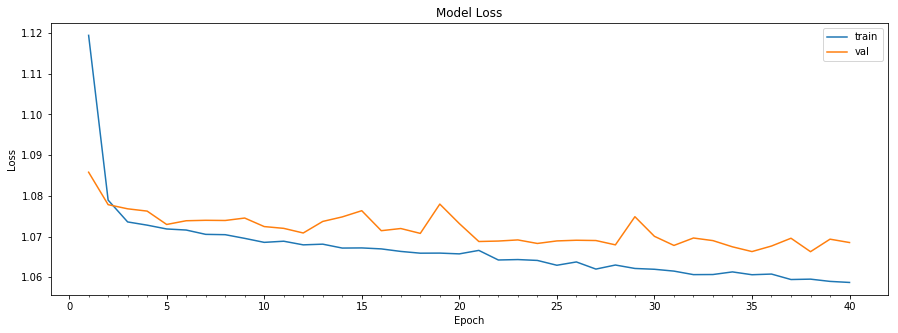

In [72]:
plot_model_history(bigram_model_info.history)

In [73]:
bigram_first_model_preds = bi_grams_model.predict([x_test_text, x_test_description, x_test_name])
bigram_test_score1 = check_categorical_accuracy(y_test_for_lstm,convert_to_one_hot(bigram_first_model_preds))
print("bigram pre-process score on test {}%".format(round(bigram_test_score1,4) * 100))

bigram pre-process score on test 42.35%


According to the best validation result: 0.4420 we will stay with the unigrams columns.
We will try to improve the model by using embedding layer.
Since we are using index to represent the words we got a problem of ranking that will affect badly on the results.<br>
The embedding will take care of this problem.<br>
Due to a dimension problem with embedding concatenation we will not use the name as a feature.

In [74]:
inp_text = Input((10,),name='text_inp')
inp_description = Input((10,),name='desc_inp')

emb_words = Embedding(10000, 100, input_length=10)
x = concatenate([emb_words(inp_text), emb_words(inp_description)], axis=1)
x = LSTM(10)(x)
output = Dense(4, activation='softmax')(x)

embd_model = Model([inp_text, inp_description], output)
embd_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
embd_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_inp (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
desc_inp (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      1000000     text_inp[0][0]                   
                                                                 desc_inp[0][0]                   
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 20, 100)      0           embedding_1[0][0]                
          

In [75]:
def transform_df2(df):
    new_df = []
    for i in range(df.shape[0]):
        new_df.append(pd.DataFrame(df).iloc[i][0])
    return np.array(new_df)

In [76]:
X_text = transform_df2(X_data_for_lstm.text)
X_description = transform_df2(X_data_for_lstm.description)

X_test_text = transform_df2(x_test_for_lstm.text)
X_test_description = transform_df2(x_test_for_lstm.description)

In [77]:
cp = ModelCheckpoint('embd_model_weights.h5',save_best_only=True)
es = EarlyStopping( patience=5,restore_best_weights=True)

lstm_model_info = embd_model.fit([X_text,X_description],
                            to_categorical(y_data_for_lstm),
                            batch_size=batch_s,
                            validation_split=0.2, 
                            epochs=ephocs, 
                            callbacks=[cp,es])

Train on 7584 samples, validate on 1896 samples
Epoch 1/40
7584/7584 [==============================] - 16s 2ms/step - loss: 1.0999 - acc: 0.5053 - val_loss: 0.9548 - val_acc: 0.5475
Epoch 2/40
7584/7584 [==============================] - 15s 2ms/step - loss: 0.8221 - acc: 0.6537 - val_loss: 0.8703 - val_acc: 0.5944
Epoch 3/40
7584/7584 [==============================] - 15s 2ms/step - loss: 0.6724 - acc: 0.7476 - val_loss: 0.8623 - val_acc: 0.6145
Epoch 4/40
7584/7584 [==============================] - 16s 2ms/step - loss: 0.5382 - acc: 0.8153 - val_loss: 0.9153 - val_acc: 0.6155
Epoch 5/40
7584/7584 [==============================] - 15s 2ms/step - loss: 0.4363 - acc: 0.8637 - val_loss: 0.9948 - val_acc: 0.6050
Epoch 6/40
7584/7584 [==============================] - 15s 2ms/step - loss: 0.3553 - acc: 0.8939 - val_loss: 1.0607 - val_acc: 0.6013
Epoch 7/40
7584/7584 [==============================] - 15s 2ms/step - loss: 0.2994 - acc: 0.9205 - val_loss: 1.1272 - val_acc: 0.6092
Epoch 8

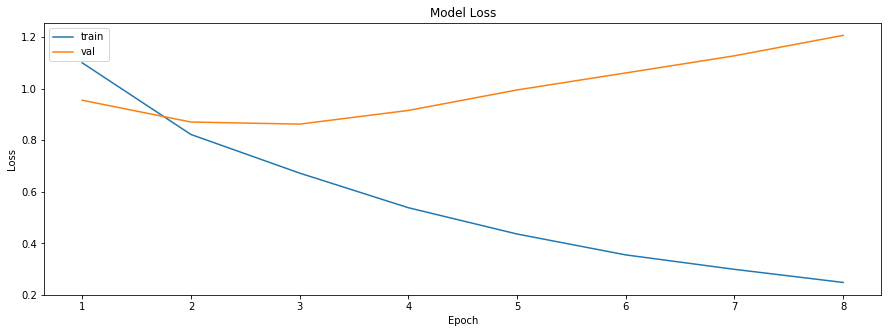

In [78]:
plot_model_history(lstm_model_info.history)

We can see that there is overfitting from epoch number 2.<br>
We used callback which takes the best weights by val_loss.

In [79]:
embd_model_preds = embd_model.predict([X_test_text, X_test_description])
embd_lstm_test_score2 = check_categorical_accuracy(y_test_for_lstm,convert_to_one_hot(embd_model_preds))
print("Embedding LSTM score on test {}%".format(round(embd_lstm_test_score2,4) * 100))

Embedding LSTM score on test 61.53999999999999%


We can see 10% improvment but still, the logisticRegression is the best among the models.

In [80]:
inp_text = Input((10,),name='text_inp')
inp_description = Input((10,),name='desc_inp')

emb_words = Embedding(10000, 100, input_length=10)
x = concatenate([emb_words(inp_text), emb_words(inp_description)], axis=1)
x = LSTM(4,dropout=0.3,recurrent_dropout=0.2,kernel_regularizer='l2',activation='softmax')(x)
# output = Dense(4, activation='softmax')(x)

regularized_embd_model = Model([inp_text, inp_description], x)
regularized_embd_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
regularized_embd_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_inp (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
desc_inp (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 100)      1000000     text_inp[0][0]                   
                                                                 desc_inp[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 20, 100)      0           embedding_2[0][0]                
          

In [81]:
cp = ModelCheckpoint('reg_embd_weights.h5',save_best_only=True)
es = EarlyStopping(patience=5,restore_best_weights=True)

lstm_model_info = regularized_embd_model.fit([X_text,X_description],
                            to_categorical(y_data_for_lstm),
                            batch_size=batch_s,
                            validation_split=0.2, 
                            epochs=ephocs, 
                            callbacks=[cp,es])

Train on 7584 samples, validate on 1896 samples
Epoch 1/40
7584/7584 [==============================] - 19s 3ms/step - loss: 1.3258 - acc: 0.4507 - val_loss: 1.1767 - val_acc: 0.4979
Epoch 2/40
7584/7584 [==============================] - 17s 2ms/step - loss: 1.1134 - acc: 0.5212 - val_loss: 1.0677 - val_acc: 0.5327
Epoch 3/40
7584/7584 [==============================] - 18s 2ms/step - loss: 0.8964 - acc: 0.6647 - val_loss: 0.9377 - val_acc: 0.6398
Epoch 4/40
7584/7584 [==============================] - 17s 2ms/step - loss: 0.6874 - acc: 0.7874 - val_loss: 0.8996 - val_acc: 0.6435
Epoch 5/40
7584/7584 [==============================] - 17s 2ms/step - loss: 0.5520 - acc: 0.8423 - val_loss: 0.9128 - val_acc: 0.6308
Epoch 6/40
7584/7584 [==============================] - 18s 2ms/step - loss: 0.4698 - acc: 0.8735 - val_loss: 0.9438 - val_acc: 0.6292
Epoch 7/40
7584/7584 [==============================] - 17s 2ms/step - loss: 0.4185 - acc: 0.8931 - val_loss: 0.9632 - val_acc: 0.6208
Epoch 8

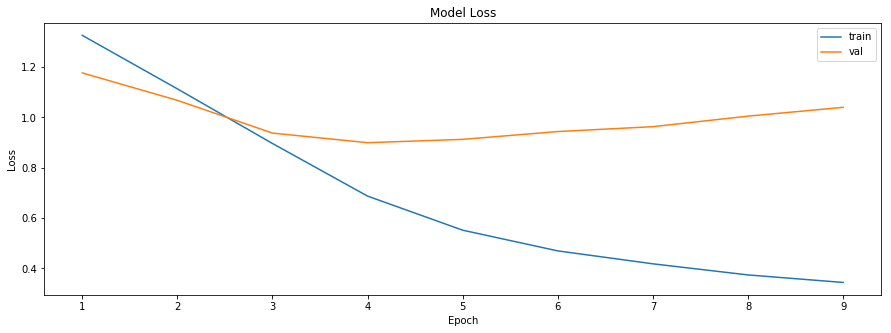

In [82]:
plot_model_history(lstm_model_info.history)

In [83]:
embd_model_preds = regularized_embd_model.predict([X_test_text, X_test_description])
embd_lstm_test_score3 = check_categorical_accuracy(y_test_for_lstm,convert_to_one_hot(embd_model_preds))
print("Embedding LSTM score on test {}%".format(round(embd_lstm_test_score3,4) * 100))

Embedding LSTM score on test 63.519999999999996%


We did alot of work until now so, we will show a summary of our progress until now with the next table with all the model and pre-process combination.<br>
We will mark the best result with a green mark.<br>

In [106]:
##### We will add some utils methods 
def create_table():
        table = {}
        table['Male Naiive baseline'] = {}
        table['Male Naiive baseline']['uni-gram pre-process'] = 'NO'
        table['Male Naiive baseline']['bi-gram pre-process'] = 'NO'
        table['Male Naiive baseline']['tunned parameter'] = 'NO'
        table['Male Naiive baseline']['validation score'] = accuracy_score(y_data, y_pred_male_train)
        table['Male Naiive baseline']['test score '] = accuracy_score(y_test, y_pred_male)

        table['Female Naiive baseline'] = {}
        table['Female Naiive baseline']['uni-gram pre-process'] = 'NO'
        table['Female Naiive baseline']['bi-gram pre-process'] = 'NO'
        table['Female Naiive baseline']['tunned parameter'] = 'NO'
        table['Female Naiive baseline']['validation score'] = accuracy_score(y_data, y_pred_female_train)
        table['Female Naiive baseline']['test score '] = accuracy_score(y_test, y_pred_female)
        
        table['#1 MultinomialNB'] = {}
        table['#1 MultinomialNB']['uni-gram pre-process'] = 'YES'
        table['#1 MultinomialNB']['bi-gram pre-process'] = 'NO'
        table['#1 MultinomialNB']['tunned parameter'] = 'NO'
        table['#1 MultinomialNB']['validation score'] = val_score_NB_unigram
        table['#1 MultinomialNB']['test score '] = test_score_NB_unigram
        
        table['#2 MultinomialNB'] = {}
        table['#2 MultinomialNB']['uni-gram pre-process'] = 'YES'
        table['#2 MultinomialNB']['bi-gram pre-process'] = 'YES'
        table['#2 MultinomialNB']['tunned parameter'] = 'NO'
        table['#2 MultinomialNB']['validation score'] = val_score_NB_bigram
        table['#2 MultinomialNB']['test score '] = test_score_NB_bigram

        table['#3 MultinomialNB'] = {}
        table['#3 MultinomialNB']['uni-gram pre-process'] = 'YES'
        table['#3 MultinomialNB']['bi-gram pre-process'] = 'NO'
        table['#3 MultinomialNB']['tunned parameter'] = 'alpha = 0.4'
        table['#3 MultinomialNB']['validation score'] = val_score_NB_alpha_opt
        table['#3 MultinomialNB']['test score '] = test_score_NB_alpha_opt

        table['#1 LogisticRegression'] = {}
        table['#1 LogisticRegression']['uni-gram pre-process'] = 'YES'
        table['#1 LogisticRegression']['bi-gram pre-process']  = 'NO'
        table['#1 LogisticRegression']['tunned parameter']     = 'NO'
        table['#1 LogisticRegression']['validation score']     = val_score_LR_unigram
        table['#1 LogisticRegression']['test score ']          = test_score_LR_unigram
        
        table['#2 LogisticRegression'] = {}
        table['#2 LogisticRegression']['uni-gram pre-process'] = 'YES'
        table['#2 LogisticRegression']['bi-gram pre-process']  = 'YES'
        table['#2 LogisticRegression']['tunned parameter']     = 'NO'
        table['#2 LogisticRegression']['validation score']     = val_score_LR_bigram
        table['#2 LogisticRegression']['test score ']          = test_score_LR_bigram

        table['#3 LogisticRegression'] = {}
        table['#3 LogisticRegression']['uni-gram pre-process'] = 'YES'
        table['#3 LogisticRegression']['bi-gram pre-process']  = 'NO'
        table['#3 LogisticRegression']['tunned parameter']     = "penalty = 'l2'"
        table['#3 LogisticRegression']['validation score']     = val_score_LR_penalty
        table['#3 LogisticRegression']['test score ']          = test_score_LR_penalty      

        table['#1 LSTM'] = {}
        table['#1 LSTM']['uni-gram pre-process'] = 'YES'
        table['#1 LSTM']['bi-gram pre-process']  = 'NO'
        table['#1 LSTM']['tunned parameter']     = 'optimizer = adamax'
        table['#1 LSTM']['validation score']     = 0.4552
        table['#1 LSTM']['test score ']          = model_test_score1
        
        table['#2 LSTM'] = {}
        table['#2 LSTM']['uni-gram pre-process'] = 'NO'
        table['#2 LSTM']['bi-gram pre-process'] = 'YES'
        table['#2 LSTM']['tunned parameter'] = 'NO'
        table['#2 LSTM']['validation score'] = 0.4420
        table['#2 LSTM']['test score '] =  bigram_test_score1

        table['#3 LSTM'] = {}
        table['#3 LSTM']['uni-gram pre-process'] = 'YES'
        table['#3 LSTM']['bi-gram pre-process']  = 'NO'
        table['#3 LSTM']['tunned parameter']     = 'Architecture improvment with embedding'
        table['#3 LSTM']['validation score']     = 0.6076
        table['#3 LSTM']['test score ']          = embd_lstm_test_score2

        table['#4 LSTM'] = {}
        table['#4 LSTM']['uni-gram pre-process'] = 'YES'
        table['#4 LSTM']['bi-gram pre-process']  = 'NO'
        table['#4 LSTM']['tunned parameter']     = 'Architecture improvment, avoiding overfit'
        table['#4 LSTM']['validation score']     = 0.6551
        table['#4 LSTM']['test score ']          = embd_lstm_test_score3
        


        columnsTitles=['uni-gram pre-process',
                       'bi-gram pre-process',
                       'tunned parameter',
                       'validation score',
                       'test score ']
    
        df = pd.DataFrame.from_dict(table).T.reindex(columns=columnsTitles)
        return df
    

In [107]:
create_table().style.apply(lambda x: ['background: lightgreen' if x.name == '#3 MultinomialNB' else '' for i in x], 
                       axis=1)

,uni-gram pre-process,bi-gram pre-process,tunned parameter,validation score,test score
Male Naiive baseline,NO,NO,NO,0.252848,0.258541
Female Naiive baseline,NO,NO,NO,0.387658,0.397301
#1 MultinomialNB,YES,NO,NO,0.66614,0.663855
#2 MultinomialNB,YES,YES,NO,0.64726,0.64825
#3 MultinomialNB,YES,NO,alpha = 0.4,0.68228,0.667651
#1 LogisticRegression,YES,NO,NO,0.67205,0.664277
#2 LogisticRegression,YES,YES,NO,0.67215,0.664277
#3 LogisticRegression,YES,NO,penalty = 'l2',0.67205,0.664277
#1 LSTM,YES,NO,optimizer = adamax,0.4552,0.471109
#2 LSTM,NO,YES,NO,0.442,0.42345


We can see that '#3 MultinomialNB' got the best validation results with 0.68228 (validation) and we will consider this model as our best model.

### Q3<br>
We collected 15,030 tweets from US which was most popular due to our exploration.<br>
The code for the collection of the tweets is commented because it doesn't need to be run again:

In [89]:
# import tweepy
# from tweepy import OAuthHandler

# consumer_key = ''
# consumer_secret = ''
# access_token = ''
# access_secret = ''

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)

# from tweepy import Stream
# from tweepy.streaming import StreamListener
# import json

# class MyListener(StreamListener):
#     tweets_count = 0
    
#     def on_data(self, data):
#         try:
#             with open('tweets.json', 'a') as f:
#                 data_json = json.loads(data)
#                 if data_json['place'] != None and data_json['place']['country_code'] == 'US':
#                     f.write(data)
#                     self.tweets_count += 1
#                     print(self.tweets_count)
#             if self.tweets_count >= 15000:
#                 return False
#             else:
#                 return True
#         except BaseException as e:
#             print("ERROR on_data: %s" % str(e))
#         return True
    
#     def on_error(self, status):
#         print(status)
#         return True
      
# listener = MyListener()
# twitter_stream = Stream(auth, listener)
# twitter_stream.sample()


We will Repeat the same pre-processing from Question 1.

In [90]:
lines = []
with open('tweets.json', 'r') as f:
    lines = f.readlines()
    
lines = list(filter(lambda x: x != '\n', lines))
tweets = list(map(lambda x: json.loads(x), lines))
for i, key in enumerate(tweets[0].keys()):
    print('{}) {}'.format(i, key))

0) created_at
1) id
2) id_str
3) text
4) source
5) truncated
6) in_reply_to_status_id
7) in_reply_to_status_id_str
8) in_reply_to_user_id
9) in_reply_to_user_id_str
10) in_reply_to_screen_name
11) user
12) geo
13) coordinates
14) place
15) contributors
16) quoted_status_id
17) quoted_status_id_str
18) quoted_status
19) quoted_status_permalink
20) is_quote_status
21) extended_tweet
22) quote_count
23) reply_count
24) retweet_count
25) favorite_count
26) entities
27) favorited
28) retweeted
29) filter_level
30) lang
31) timestamp_ms


We will use the same features we used in the training stage

In [91]:
features = ['id','text','user']
tweets_df = pd.DataFrame.from_dict(tweets)
tweets_df = tweets_df[features]
tweets_df.head()

,id,text,user
0,1092055417759416320,#PublicHealthHaiku\nRespect and honor -\nLove ...,"{'id': 234924597, 'id_str': '234924597', 'name..."
1,1092055451330592774,@PhoenixGRIT2Cnt @PALucier @WayneDupreeShow It...,"{'id': 563780506, 'id_str': '563780506', 'name..."
2,1092055497472204800,"still up , let me go to bed","{'id': 57673882, 'id_str': '57673882', 'name':..."
3,1092055501653852160,Shave kit/make up bag I just finished https://...,"{'id': 995045622, 'id_str': '995045622', 'name..."
4,1092055564585181190,Lmaooo I just might bro,"{'id': 972243180, 'id_str': '972243180', 'name..."


We will transform the data to the same form of the train dataset in order to use the same methods of pre processing.

In [92]:
tweets_df['description'] = tweets_df.user.apply(lambda x: x['description'])
tweets_df['name'] = tweets_df.user.apply(lambda x: x['screen_name'])
tweets_df.drop('user', axis=1, inplace=True)
tweets_df.head()

,id,text,description,name
0,1092055417759416320,#PublicHealthHaiku\nRespect and honor -\nLove ...,Public health activist. Boston Medical Center....,AcuOxPhD
1,1092055451330592774,@PhoenixGRIT2Cnt @PALucier @WayneDupreeShow It...,"Fiscal, Constitutional Conservative, Bama, Tex...",dbox91
2,1092055497472204800,"still up , let me go to bed",https://m.soundcloud.com/1stevepierre/close-fr...,6IERRE
3,1092055501653852160,Shave kit/make up bag I just finished https://...,somewhere between living and dying chat snap k...,shea_bull
4,1092055564585181190,Lmaooo I just might bro,Gucci told me u could get lost in the sauce an...,Bos_Laflare


In [93]:
tweets_df['text'] = [preprocess(s) for s in tweets_df['text']]
tweets_df['description'] = [preprocess(s) for s in tweets_df['description']]

tweets_df['text'] = tweets_df['text'].apply(lambda x : [item for item in x if item not in stop])
tweets_df['description'] = tweets_df['description'].apply(lambda x : [item for item in x if item not in stop])
tweets_df.head()

,id,text,description,name
0,1092055417759416320,"[publichealthhaiku, respect, honor, love, beat...","[public, health, activist, boston, medical, ce...",AcuOxPhD
1,1092055451330592774,"[phoenixgritcnt, palucier, waynedupreeshow, fu...","[fiscal, nstitutional, nservative, bama, texan...",dbox91
2,1092055497472204800,"[still, let, go, bed]","[soundcloud, stevepierre, close, friend]",6IERRE
3,1092055501653852160,"[shave, kit, make, bag, finished, ttsmstkhpf]","[somewhere, living, dying, chat, snap, kincer]",shea_bull
4,1092055564585181190,"[lmaooo, might, bro]","[gucci, told, u, uld, get, lost, sauce, life, ...",Bos_Laflare


Let's find the most common words before pre-proccesing the data

In [94]:
def get_all_words(tweets_df):
    tweets_all_words = []
    tweets_df.text.apply(lambda x: tweets_all_words.extend(x))
    tweets_df.description.apply(lambda x: tweets_all_words.extend(x))
    return tweets_all_words

none     1455
love     1322
like     1140
u        1102
tweet    1026
job       808
life      797
wa        775
need      748
get       730
dtype: int64


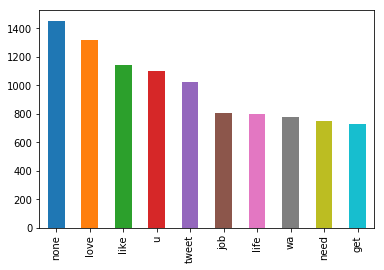

In [95]:
tweets_all_words = get_all_words(tweets_df)
tweets_common_words = pd.Series(tweets_all_words).value_counts()[:10]
print_and_plot(tweets_common_words)

And now we will filter the words and we will stay with only top 10000 words from the train.

In [96]:
tweets_df.description = tweets_df.description.apply(lambda x: list(filter(lambda word: word in top_words, x)))
tweets_df.text = tweets_df.text.apply(lambda x: list(filter(lambda word: word in top_words, x)))
tweets_df.head()

,id,text,description,name
0,1092055417759416320,"[respect, honor, love, beat, hate, every, time...","[public, health, activist, boston, medical, ce...",AcuOxPhD
1,1092055451330592774,"[funny, never, got, ta]","[fiscal, nstitutional, nservative, bama, texan...",dbox91
2,1092055497472204800,"[still, let, go, bed]","[soundcloud, close, friend]",6IERRE
3,1092055501653852160,"[shave, kit, make, bag, finished]","[somewhere, living, dying, chat, snap]",shea_bull
4,1092055564585181190,"[might, bro]","[gucci, told, u, uld, get, lost, sauce, life, ...",Bos_Laflare


In [97]:
tweets_all_words = get_all_words(tweets_df)
tweets_all_words[:10]

['respect',
 'honor',
 'love',
 'beat',
 'hate',
 'every',
 'time',
 'gift',
 'funny',
 'never']

##### Comparing to the train dataset common words and term frequency:

none     1455
love     1322
like     1140
u        1102
tweet    1026
job       808
life      797
wa        775
need      748
get       730
dtype: int64


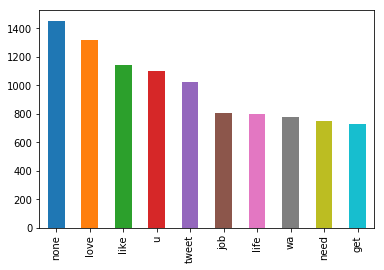

In [98]:
tweets_common_words = pd.Series(tweets_all_words).value_counts()[:10]
print_and_plot(tweets_common_words)

love    1829
_ù      1508
like    1428
û       1372
get     1360
one     1190
ü       1177
http    1130
life    1104
wa      1097
dtype: int64


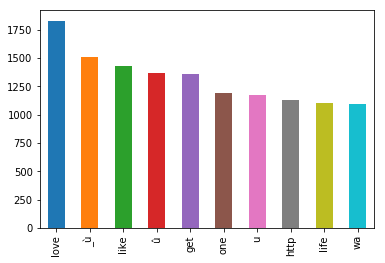

In [99]:
print_and_plot(pd.Series(dict(all_words.most_common(10))))

We can see that love and like are in the top 5 words for both of the datasets.<br>
Let's print the precentage of the intersection words for the two datasets, the new tweets and the train.<br>
We will look on the 1000 most common.

In [100]:
def calc_intersection(setA,setB):
    intersec_len = len(setA.intersection(setB))
    return intersec_len*100/len(setB)

In [101]:
tweets_1000_common_set = set(pd.Series(tweets_all_words).value_counts()[:1000].keys())
train_1000_words_set = set(dict(all_words.most_common(1000)).keys())
print("Precentage of words from new tweets that apear in the train: {}%".format(calc_intersection(tweets_1000_common_set,train_1000_words_set)))

Precentage of words from new tweets that apear in the train: 74.2%


We can see that there is huge similarity in the terms occurrence, about 74.3%.<br>
We believe that the prediction distribution will look similar to the train dataset due to this information.

#### Terms distribution

In [102]:
tweets_words_df = pd.DataFrame(nltk.FreqDist(tweets_all_words),index=[0])

In [103]:
tweets_all_words_dict = dict(nltk.FreqDist(tweets_all_words))

In [110]:
tweets_term_dist = {}
for _,count in tweets_all_words_dict.items():
    tweets_term_dist[count] = tweets_term_dist.get(count,0)+1
sorted_dict = dict(sorted(tweets_term_dist.items(),reverse=True,key=lambda x:x[0]))

Let's look on this distribution in the next graph

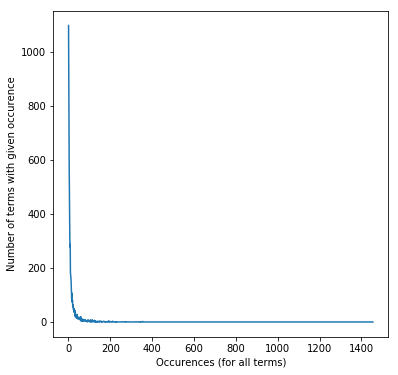

In [111]:
fig, ax = plt.subplots(figsize=(6,6))
plt.xlabel('Occurences (for all terms)')
plt.ylabel('Number of terms with given occurence')
plt.show(plt.plot(list(sorted_dict.keys()),list(sorted_dict.values())))

We can see long tail plot, which means that there are many rare words.

## Q4

We will use the best gender classification model from Q2, LogisticRegression.
And we will predict and analyze the gender of the tweets' authors.

In [112]:
tweet_text_as_description =  tweets_df[['description']].rename(columns={'description': 'text'})
# concatenate text and description for one column.
tweets_X_data = tweets_df[['text']] + tweet_text_as_description
tweets_X_data = tweets_X_data['text'].apply(lambda x: ' '.join(x))

In [113]:
tweets_df[['text']].head()

,text
0,"[respect, honor, love, beat, hate, every, time..."
1,"[funny, never, got, ta]"
2,"[still, let, go, bed]"
3,"[shave, kit, make, bag, finished]"
4,"[might, bro]"


We have joined all the tokens after concatenation of the text and description columns to a complete sentence.<br>
We did it in order to acheive the correcet format to use the defined pipeline method above.

In [114]:
tweets_X_data[:3]

0    respect honor love beat hate every time gift p...
1    funny never got ta fiscal nstitutional nservat...
2             still let go bed soundcloud close friend
Name: text, dtype: object

We will use the best model according to the validation results, optimal_alpha_nb (which is MultinomialNB with optimal alpha)

In [115]:
tweets_gender_preds = pd.DataFrame(optimal_alpha_nb.predict(tweets_X_data))

Since the most common words and the train are pretty similar to the tweets we have download we can guess that the distribution will look similar also.<br>
Let's look on the predicted gender histogram along the train histogram.

#### Predictions:

In [116]:
gender_freq = nltk.FreqDist([num[0] for num in tweets_gender_preds.values])
id_to_gender = {2:'Brand',1:'Female',0:'Male'}
for gender,amounts in gender_freq.items():
    print("Gender: {}, amount {}".format(id_to_gender[gender], amounts))

Gender: Male, amount 1447
Gender: Brand, amount 6820
Gender: Female, amount 6763


Reminder :<br>
0 - Male<br>
1 - Female<br>
2 - Brand<br>

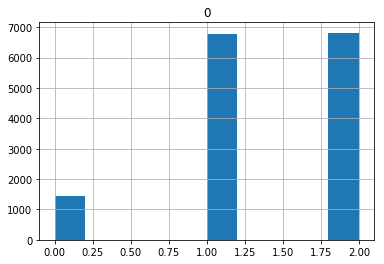

In [117]:
plt.show(tweets_gender_preds.hist())

We can compare this histogram to the train dataset distibution.

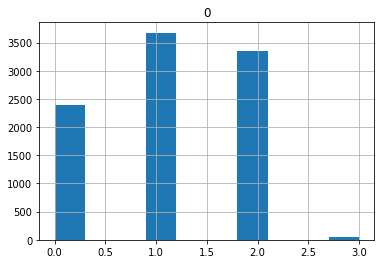

In [118]:
plt.show(y_data.hist())

We can see that it is pretty natural that the most common tweets will be by females and brands, same as refelected in the train dataset, which our model learned to classify from.

## Conclusions

We will describe our process, the task challenges, we will explain our solution and offer some improvments.
<br>
<br>
#### Pre-Proccessing , Features:
>1. Removing Stop Words.<br>
> Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For this mission we used  nltk stopwords set.
>2. Filtering Top 10,000 common words<br>
This amount of words is actually covering most of the tokens occurences. It is also usefull to use the 10,000 words filtering in the test dataset in order to avoid unseen words. 
>3. Lemmatizing.<br>
Documents are going to use different forms of a word, such as organize, organizes, and organizing.<br>
The goal of lemmatization is to reduce inflectional forms.For this mission we also used nltk lemmatize method.
>5. We have used CountVectorizer + TFidfTransformer as a representation to the text and the description.<br>
We have also tried to use two combinations of ngrams, unigram and bigram as part of the CountVectorizer parameters.

#### Parameters Tunning:
>1. For the multinomialNB we have tuned the alpha parameter in order to achieve optimal results.
>2. For the logisticRegression we have tried to use penalty regularization as parameter tunning.

#### Validation Strategy:
>1. K-Folds cross-validator<br>
This strategy is splitting the dataset into k consecutive folds and
each fold is then used once as a validation while the k - 1 remaining folds form the training set.
This strategy is suited for our case since our dataset is pretty small and we want to have low variance between the train and the validation.

#### Models and Architecture:
>1. Machine Learning Models: We will not elaborate here since we talked about this enough in Question 2, but the two models types we have used as machine learning models were LogisticRegression and MultinomialNB.
>2. Deep Learning Models (LSTM) - We chose to use the LSTM model since it's best suited to the text classification task because the abillity to take into account words context and words long or short dependency in a given sentence. We have tried several options for the number of the hidden states and found that 4-10 hidden states is an optimal number for us. In one of the architectures we have tried to use dense(4) with softmax in the last layer in order to have vector of size 4 with class probability values for each gender. We have used categorical-crossentropy loss function which is suited to classification problems.
>3. Embedding - Again, we will not elaborate on this one since we already explained (in Question 2) why we chose to improve our model with embedding layer. But we will mention that this change has improved our model in 10% accuracy on validation and test.
#### Overfitting Problem
>1. We can easily see in the plot of the LSTM model fitting that we had an overfitting problem.
in order to avoid this problem we did two things: the first was to use callbacks that save the best model weights, the second was early-stopping for the learning stage and the last one was using dropout and regularization parameters.<br> 
That's helped a little bit.
#### Ways to Improve
>1. The first thing we thought that can improve our results was using the profile images.<br>
We could use another gender classifier for the images and using this classifier as a feature extractor for the main classifier which will include the all other features.
>2. Named Entity Recognition feature. Tweets might include a references for an entities in the text which might point on the tweet writer gender.
>3. Other feature exctration like Sentiment Analysis by one of the classifiers we can find on the internet. The tweet sentiment might help pointing on the author's gender.

We are very happy with the results you can find above. We have tried alot of pre-processing techniques, we explored the data, and have deepened our understanding in machine learning, deep learning and particularly about LSTM and we also used the Tweeter API for the first time.
We hope you enjoyed our notebook :)

